# **DATA SCIENCE - FINAL PROJECT**

The dataset used contains a collection of customer data, product information, transaction activities and visitor activities on a site. This dataset provides a real or realistic picture of e-commerce activities. This dataset has 4 sub datasets/data tables, namely Click Stream, Customer, Product, and Transaction.

The stages of processing this dataset are:
1. Import Library
2. Pre-Processing Data
3. Exploratory Data Analysis
4. Features Engineering
5. Define Customer Churn
6. Modelling
7. Cros Validation
8. Conclusion

#**IMPORT LIBRARIES AND READ DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
import datetime
from datetime import timedelta
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')

In [ ]:
# IMPORT DATASET CLICK STREAM
click_stream = pd.read_csv('/content/drive/MyDrive/DATASET_FPDS/click_stream.csv')
# IMPORT DATASET CUSTOMER
customer = pd.read_csv('/content/drive/MyDrive/DATASET_FPDS/customer.csv')
# IMPORT DATASET PRODUCT
product = pd.read_csv('/content/drive/MyDrive/DATASET_FPDS/product.csv', error_bad_lines=False)
# IMPORT DATASET TRANSACTION
transaction = pd.read_csv('/content/drive/MyDrive/DATASET_FPDS/transactions.csv')

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

**Drop columns**

In [ ]:
# drop columns click stream
click_stream = click_stream.drop(['event_id','event_metadata'], axis=1)
# drop columns customer
customer = customer.drop(['first_name','last_name','username','email','device_id','home_country','home_location_lat','home_location_long'], axis=1)
# drop columns transaction
transaction = transaction.drop(['booking_id','product_metadata','shipment_location_lat','shipment_location_long'], axis=1)

Now we have successfully droped columns. Lets merge the data.

# **MERGE DATA**

In [ ]:
# merge dataset  click stream and transactions
mergedata = pd.merge(click_stream, transaction, how = 'inner', on='session_id')
# merge dataset click stream, transactions , and customer
mergedata = pd.merge(mergedata, customer, how = 'inner', on='customer_id')

In [ ]:
mergedata = mergedata.sort_values('created_at').groupby('customer_id').tail(1)
mergedata.reset_index(drop = True, inplace = True)
mergedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50704 entries, 0 to 50703
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   session_id           50704 non-null  object
 1   event_name           50704 non-null  object
 2   event_time           50704 non-null  object
 3   traffic_source       50704 non-null  object
 4   created_at           50704 non-null  object
 5   customer_id          50704 non-null  int64 
 6   payment_method       50704 non-null  object
 7   payment_status       50704 non-null  object
 8   promo_amount         50704 non-null  int64 
 9   promo_code           18144 non-null  object
 10  shipment_fee         50704 non-null  int64 
 11  shipment_date_limit  50704 non-null  object
 12  total_amount         50704 non-null  int64 
 13  gender               50704 non-null  object
 14  birthdate            50704 non-null  object
 15  device_type          50704 non-null  object
 16  devi

**Export dataset to csv**

In [ ]:
# mergedata.to_csv('outputdata.csv', index=True)

In [ ]:
# IMPORT DATASET MERGE OUTPUT
# mergedata = pd.read_csv('/content/outputdata.csv')#

# **DATA PREPROCESSING**

The first thing before data exploration is to combine sub datasets consisting of Click Stream, Customer and Transaction datasets.

In [ ]:
# menghitung total dari promo amount per customer
df_count = transaction.groupby('customer_id').agg(total_promo_amount=('promo_amount','sum'))
df_count

,total_promo_amount
customer_id,
3,131082
8,7699
9,0
11,9492
15,16362
...,...
99992,12442
99995,63674
99997,0


In [ ]:
# menghitung berapa kali customer mendapatkan promo
df_count['number_of_promo'] = transaction[transaction.promo_amount!=0].groupby('customer_id').customer_id.count()
df_count['number_of_promo']

customer_id
3        27.0
8         1.0
9         NaN
11        1.0
15        4.0
         ... 
99992     2.0
99995    13.0
99997     NaN
99998     6.0
99999     NaN
Name: number_of_promo, Length: 50705, dtype: float64

In [ ]:
# menghitung berapa kali customer membatalkan transaksi
df_count['transaction_failed'] = transaction[transaction.payment_status=='Failed'].groupby('customer_id').customer_id.count()
df_count['transaction_failed']

customer_id
3        2.0
8        NaN
9        NaN
11       NaN
15       NaN
        ... 
99992    NaN
99995    1.0
99997    NaN
99998    NaN
99999    NaN
Name: transaction_failed, Length: 50705, dtype: float64

In [ ]:
# menghitung berapa kali customer melakukan transaksi
df_count['number_of_transaction'] = transaction[transaction.payment_status=='Success'].groupby('customer_id').customer_id.count()
df_count['number_of_transaction']

customer_id
3        49.0
8         7.0
9         6.0
11        1.0
15        5.0
         ... 
99992    12.0
99995    59.0
99997     1.0
99998     8.0
99999     1.0
Name: number_of_transaction, Length: 50705, dtype: float64

In [ ]:
# # menghitung total ongkir selama bertransaksi
df_count['total_shipment_fee'] = transaction.groupby('customer_id').agg(total_promo_amount=('shipment_fee','sum'))
df_count['total_shipment_fee']

customer_id
3        365000
8         45000
9         35000
11        15000
15        50000
          ...  
99992    130000
99995    550000
99997     10000
99998     55000
99999     10000
Name: total_shipment_fee, Length: 50705, dtype: int64

In [ ]:
df_count

,total_promo_amount,number_of_promo,transaction_failed,number_of_transaction,total_shipment_fee
customer_id,,,,,
3,131082,27.0,2.0,49.0,365000
8,7699,1.0,NaN,7.0,45000
9,0,NaN,NaN,6.0,35000
11,9492,1.0,NaN,1.0,15000
15,16362,4.0,NaN,5.0,50000
...,...,...,...,...,...
99992,12442,2.0,NaN,12.0,130000
99995,63674,13.0,1.0,59.0,550000
99997,0,NaN,NaN,1.0,10000


In [ ]:
# merge df_count and mergedata
mergedata = pd.merge(mergedata, df_count, how = 'inner', on='customer_id')

In [ ]:
# # menghitung berapa kali customer mendapatkan promo
# mergedata['free_shipping'] = transaction[transaction.shipment_fee==0].groupby('customer_id').customer_id.count()
# mergedata['free_shipping']

In [ ]:
mergedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50704 entries, 0 to 50703
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   session_id             50704 non-null  object 
 1   event_name             50704 non-null  object 
 2   event_time             50704 non-null  object 
 3   traffic_source         50704 non-null  object 
 4   created_at             50704 non-null  object 
 5   customer_id            50704 non-null  int64  
 6   payment_method         50704 non-null  object 
 7   payment_status         50704 non-null  object 
 8   promo_amount           50704 non-null  int64  
 9   promo_code             18144 non-null  object 
 10  shipment_fee           50704 non-null  int64  
 11  shipment_date_limit    50704 non-null  object 
 12  total_amount           50704 non-null  int64  
 13  gender                 50704 non-null  object 
 14  birthdate              50704 non-null  object 
 15  de

# **CLEANING DATA**

In [ ]:
# check for duplicate data
mergedata.duplicated().sum()

0

There are no duplicate data. Now, let's check the missing value

In [ ]:
# check for missing value
mergedata.isnull().sum()

session_id                   0
event_name                   0
event_time                   0
traffic_source               0
created_at                   0
customer_id                  0
payment_method               0
payment_status               0
promo_amount                 0
promo_code               32560
shipment_fee                 0
shipment_date_limit          0
total_amount                 0
gender                       0
birthdate                    0
device_type                  0
device_version               0
home_location                0
first_join_date              0
total_promo_amount           0
number_of_promo          11825
transaction_failed       37944
number_of_transaction      463
total_shipment_fee           0
dtype: int64

In [ ]:
# handle missing values ​​
mergedata["promo_code"].fillna('none', inplace=True)
mergedata["number_of_promo"].fillna(0, inplace=True)
mergedata["number_of_transaction"].fillna(0, inplace=True)
mergedata["transaction_failed"].fillna(0, inplace=True)

In [ ]:
# check for missing value
mergedata.isnull().sum()

session_id               0
event_name               0
event_time               0
traffic_source           0
created_at               0
customer_id              0
payment_method           0
payment_status           0
promo_amount             0
promo_code               0
shipment_fee             0
shipment_date_limit      0
total_amount             0
gender                   0
birthdate                0
device_type              0
device_version           0
home_location            0
first_join_date          0
total_promo_amount       0
number_of_promo          0
transaction_failed       0
number_of_transaction    0
total_shipment_fee       0
dtype: int64

In [ ]:
# change object data type to datetime type
time = ['event_time','birthdate', 'first_join_date', 'created_at','shipment_date_limit']

for x in time:
  mergedata[x] = pd.to_datetime(mergedata[x])

In [ ]:
mergedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50704 entries, 0 to 50703
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   session_id             50704 non-null  object             
 1   event_name             50704 non-null  object             
 2   event_time             50704 non-null  datetime64[ns, UTC]
 3   traffic_source         50704 non-null  object             
 4   created_at             50704 non-null  datetime64[ns, UTC]
 5   customer_id            50704 non-null  int64              
 6   payment_method         50704 non-null  object             
 7   payment_status         50704 non-null  object             
 8   promo_amount           50704 non-null  int64              
 9   promo_code             50704 non-null  object             
 10  shipment_fee           50704 non-null  int64              
 11  shipment_date_limit    50704 non-null  datetime64[ns, 

After handling missing values, the output data is 0. This means that there are no missing values.

**CLEANING THE PRODUCT DATASET**

In [ ]:
product.shape

(44424, 10)

In [ ]:
# Showing the top 5 data
product.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
# View data information
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [ ]:
# check for duplicate data
product.duplicated().sum()

0

There are no duplicate data. Now, let's check the missing value

In [ ]:
# check for missing value
product.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

There are some features that are missing value. That is, baseColor has 15 null values, season has 21 null values, year has 1 null values, usage has 317 null values, and productDisplayName contains 7 null values. Now, we have to clean up the missing value data by filling it with the value 'none'.

In [ ]:
# handle missing values ​​in the baseColour column
product["baseColour"].fillna('none', inplace=True)
# handle missing values ​​in the season column
product["season"].fillna('none', inplace=True)
# handle missing values ​​in the year column
product["year"].fillna(0, inplace=True)
# handle missing values ​​in the usage column
product["usage"].fillna('none', inplace=True)
# handle missing values ​​in the productDisplayName column
product["productDisplayName"].fillna('none', inplace=True)

In [ ]:
# check for missing value
product.isnull().sum()

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

utput data is 0. This means that there are no duplicate data and missing values.

# **EDA (Exploratory Data Analysis)**

## - *Distribution User by Event Name*

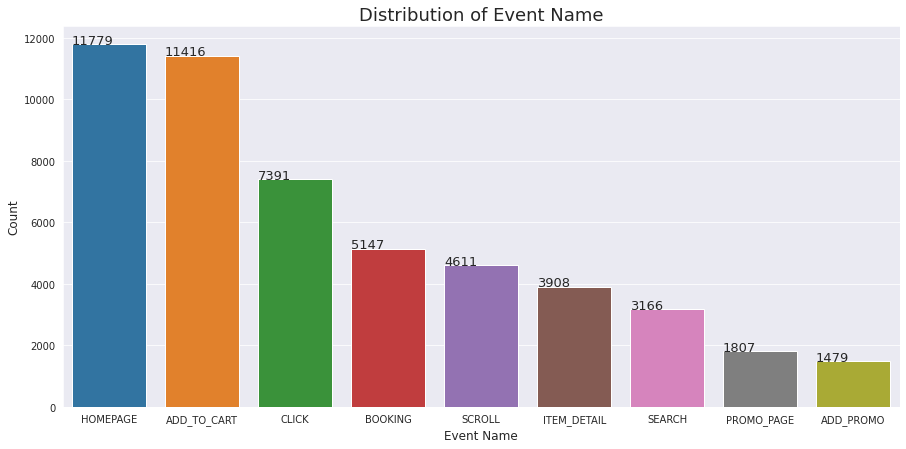

HOMEPAGE       11779
ADD_TO_CART    11416
CLICK           7391
BOOKING         5147
SCROLL          4611
ITEM_DETAIL     3908
SEARCH          3166
PROMO_PAGE      1807
ADD_PROMO       1479
Name: event_name, dtype: int64


In [ ]:
eventname_count=mergedata["event_name"].value_counts()
plt.figure(figsize=(15,7))
ax=sns.barplot(eventname_count.index, eventname_count.values)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()+10), size = 13)

plt.title('Distribution of Event Name', fontsize=18)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Event Name', fontsize=12)
plt.show()

print(eventname_count)

From the distribution of the data above, the most event name are **Booking**, and the least event name are **Promo Page**.

## - *Distribution User by Traffic Source?*

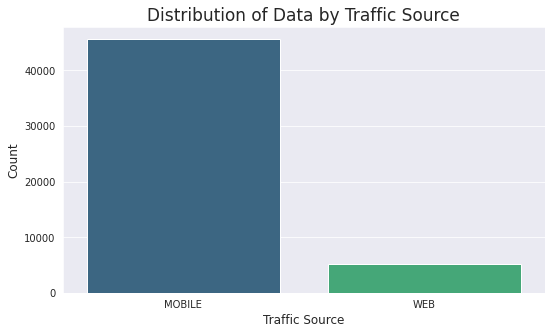

MOBILE    45583
WEB        5121
Name: traffic_source, dtype: int64


In [ ]:
# distribution of data by usage
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121)
sns.countplot(x = mergedata['traffic_source'], palette = 'viridis', ax=ax)
ax.set_title('Distribution of Data by Traffic Source', fontsize=17)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel("Count", fontsize=12)

fig.tight_layout(pad=2)
plt.show()
print(mergedata['traffic_source'].value_counts())

From the distribution of the data above, the most traffic source are **Mobile**, and the least traffic source are **Web**.

## - *Event Time Distribution*

In [ ]:
import datetime as dt
from datetime import datetime as dt2
from datetime import timedelta as td
from datetime import time as tm

In [ ]:
mergedata['event_time'] = pd.to_datetime(mergedata['event_time'])
mergedata['EventTimeYear'] = mergedata['event_time'].map(lambda date: 100*date.year)
mergedata['Date'] = mergedata['event_time'].dt.strftime('%Y')

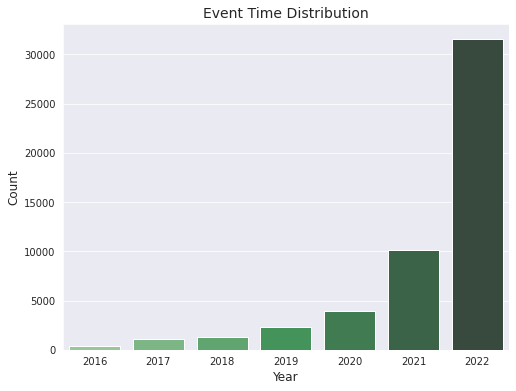

2022    31545
2021    10126
2020     3943
2019     2276
2018     1332
2017     1079
2016      403
Name: Date, dtype: int64


In [ ]:
evnttime = mergedata['Date'].value_counts()
fig = plt.figure(figsize=(8, 6))
ax = sns.countplot(x=mergedata['Date'], palette='Greens_d')

plt.title("Event Time Distribution", fontsize=14)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Year",fontsize=12)
plt.show()
print(evnttime)

From the distribution of the data above, the most transaction in 2022 with 32829 users, and the least transaction in 2016 with 403 users.

## - *Distribution Traffic Source by Year*

Text(0.5, 0, 'Year')

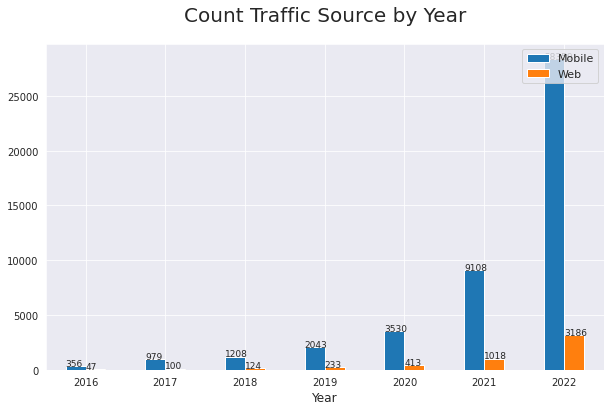

In [ ]:
ax = mergedata.groupby(['traffic_source']).Date.value_counts().unstack(0).plot.bar(figsize = (10,6))

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()+10), size = 9)

plt.legend(['Mobile', 'Web'], loc = 'upper right', prop = {'size': 11})
plt.title('Count Traffic Source by Year', size = 20, y = 1.05)
plt.xticks(rotation = 0)
plt.xlabel('Year', fontsize=12)

From the distribution of the data above, there is a significance difference using **Mobile** by **Year**, but there is less significance difference using **Web** by **Year**

## - Distribution Customer by a Gender

In [ ]:
byGender = mergedata.groupby(by=['gender']).count()
female = byGender['customer_id'][0]
male = byGender['customer_id'][1]

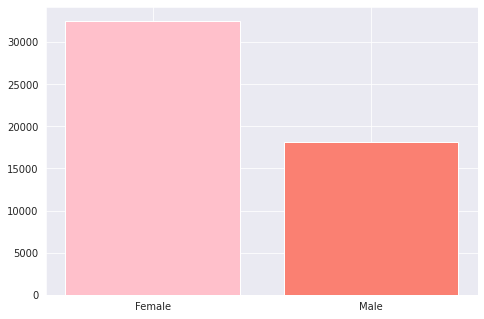

gender
F    32547
M    18157
Name: customer_id, dtype: int64

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Female', 'Male']
ax.bar(langs,[female, male], color=['pink', 'salmon'])
plt.show()
byGender['customer_id']

From the distribution of the data above, the gender with the most subscriptions is **Female**.

## - Distribution User Device Type

In [ ]:
device = mergedata.groupby(by=['device_type']).count()
iOS = device['customer_id'][1]
And = device['customer_id'][0]

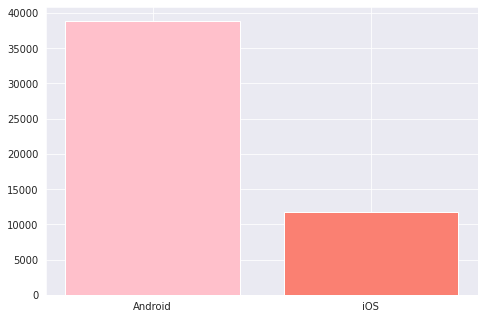

device_type
Android    38932
iOS        11772
Name: customer_id, dtype: int64

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Android', 'iOS']
ax.bar(langs,[And, iOS], color=['pink', 'salmon'])
plt.show()
device['customer_id']

From the distribution of the data above, the type of device that is most widely used by customers is **Android**.

## - Distribution User by Customer Home Location

In [ ]:
byCity = pd.pivot_table(mergedata, values='customer_id', index=['home_location'],columns=['device_type'], aggfunc='count', fill_value=0)
byCity['Jumlah pengguna'] = byCity['Android'] + byCity['iOS']
byCity

device_type,Android,iOS,Jumlah pengguna
home_location,,,
Aceh,107,34,141
Bali,578,173,751
Bangka Belitung,94,38,132
Banten,138,42,180
Bengkulu,246,95,341
Gorontalo,142,41,183
Jakarta Raya,7193,2196,9389
Jambi,160,38,198
Jawa Barat,4435,1346,5781


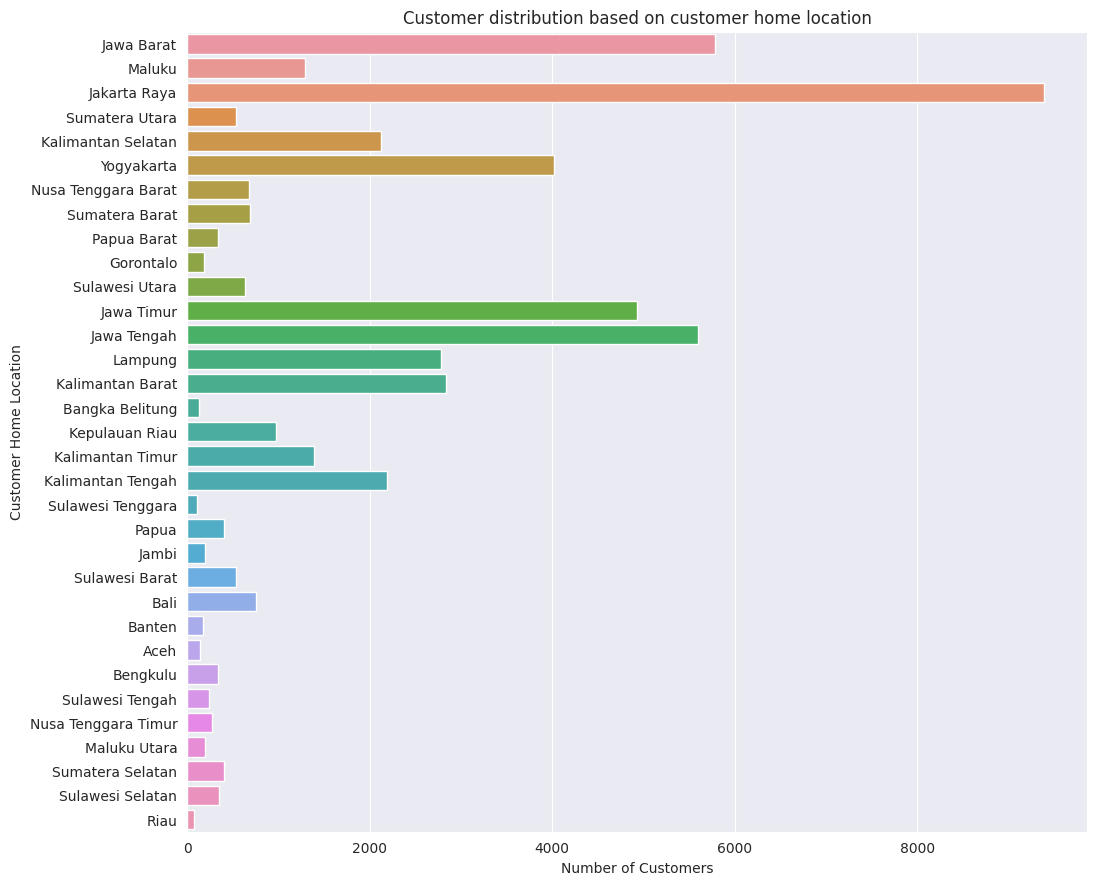

In [ ]:
fig = plt.figure(figsize=(5,10), dpi=100)
axes = fig.add_axes([0.1, 0.1, 1.8, 0.8])
sns.countplot(y='home_location', data=mergedata)
axes.set_ylabel('Customer Home Location')
axes.set_xlabel('Number of Customers')
axes.set_title('Customer distribution based on customer home location')
plt.show()

From the distribution of the data above, the majority of customers live in  **Jakarta Raya** and a minority in **Riau**.

## - What is the gender target of a product?

In [ ]:
# note : gender pada dataset produk maksudnya jenis dari produk tersebut cocok dikenakan kepada anak perempuan/laki, atau dewasa perempuan/laki
df_count = product.groupby('gender').agg(count_of_gender=('gender','count'))
df_count

,count_of_gender
gender,
Boys,830
Girls,655
Men,22147
Unisex,2161
Women,18631


Description:

- Boys = anak lak-laki

- Girls = anak perempuan

- Men = laki-laki dewasa

- Women = perempuan dewasa

- Unisex = dua gender pria dan wanita

Men       22147
Women     18631
Unisex     2161
Boys        830
Girls       655
Name: gender, dtype: int64


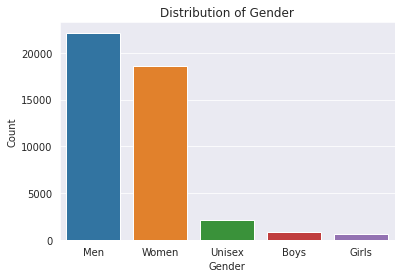

In [ ]:
gender_count=product["gender"].value_counts()
plt.title('Distribution of Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
sns.barplot(gender_count.index, gender_count.values)

print(gender_count)

From the distribution of the data above, the most targeted product to **Men** is 22147 , and the least targeted product to **Girls** is 655.

## - How about the number of product by master Category?

In [ ]:
df_count_masCat = product.groupby('masterCategory').agg(count_of_masterCategory=('masterCategory','count'))
df_count_masCat

,count_of_masterCategory
masterCategory,
Accessories,11274
Apparel,21397
Footwear,9219
Free Items,105
Home,1
Personal Care,2403
Sporting Goods,25


Text(0.5, 0, 'Master Category')

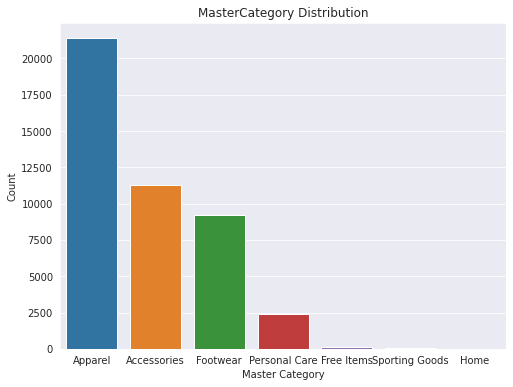

In [ ]:
#visualization of the masterCategory distribution
fig = plt.figure(figsize=(8, 6))
ax = sns.countplot(x=product['masterCategory'])

plt.title("MasterCategory Distribution")
plt.ylabel("Count")
plt.xlabel("Master Category")

From the distribution of the data above, the most products are in the **Apparel** category, and the least products are products in the **Home** category.

## - How about the number of product by subCategory?

In [ ]:
df_count_subCategory = product.groupby('subCategory').agg(count_of_subCategory=('subCategory','count'))
df_count_subCategory

,count_of_subCategory
subCategory,
Accessories,129
Apparel Set,106
Bags,3055
Bath and Body,12
Beauty Accessories,4
Belts,811
Bottomwear,2694
Cufflinks,108
Dress,478


In [ ]:
# showing the unique value of subCategory columns
product['subCategory'].unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts',
       'Flip Flops', 'Bags', 'Innerwear', 'Sandal', 'Shoe Accessories',
       'Fragrance', 'Jewellery', 'Lips', 'Saree', 'Eyewear', 'Nails',
       'Scarves', 'Dress', 'Loungewear and Nightwear', 'Wallets',
       'Apparel Set', 'Headwear', 'Mufflers', 'Skin Care', 'Makeup',
       'Free Gifts', 'Ties', 'Accessories', 'Skin', 'Beauty Accessories',
       'Water Bottle', 'Eyes', 'Bath and Body', 'Gloves',
       'Sports Accessories', 'Cufflinks', 'Sports Equipment', 'Stoles',
       'Hair', 'Perfumes', 'Home Furnishing', 'Umbrellas', 'Wristbands',
       'Vouchers'], dtype=object)

In [ ]:
# clean up duplicate data and replace data with similar sub categories
product['subCategory'] = product['subCategory'].replace({'Sandal':'Flip Flops',
                                                         'Skin':'Skincare',
                                                         'Sports Accessories':'Sports Equipment',
                                                         'Wristbands':'Accessories'})
product['subCategory'].unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts',
       'Flip Flops', 'Bags', 'Innerwear', 'Shoe Accessories', 'Fragrance',
       'Jewellery', 'Lips', 'Saree', 'Eyewear', 'Nails', 'Scarves',
       'Dress', 'Loungewear and Nightwear', 'Wallets', 'Apparel Set',
       'Headwear', 'Mufflers', 'Skin Care', 'Makeup', 'Free Gifts',
       'Ties', 'Accessories', 'Skincare', 'Beauty Accessories',
       'Water Bottle', 'Eyes', 'Bath and Body', 'Gloves',
       'Sports Equipment', 'Cufflinks', 'Stoles', 'Hair', 'Perfumes',
       'Home Furnishing', 'Umbrellas', 'Vouchers'], dtype=object)

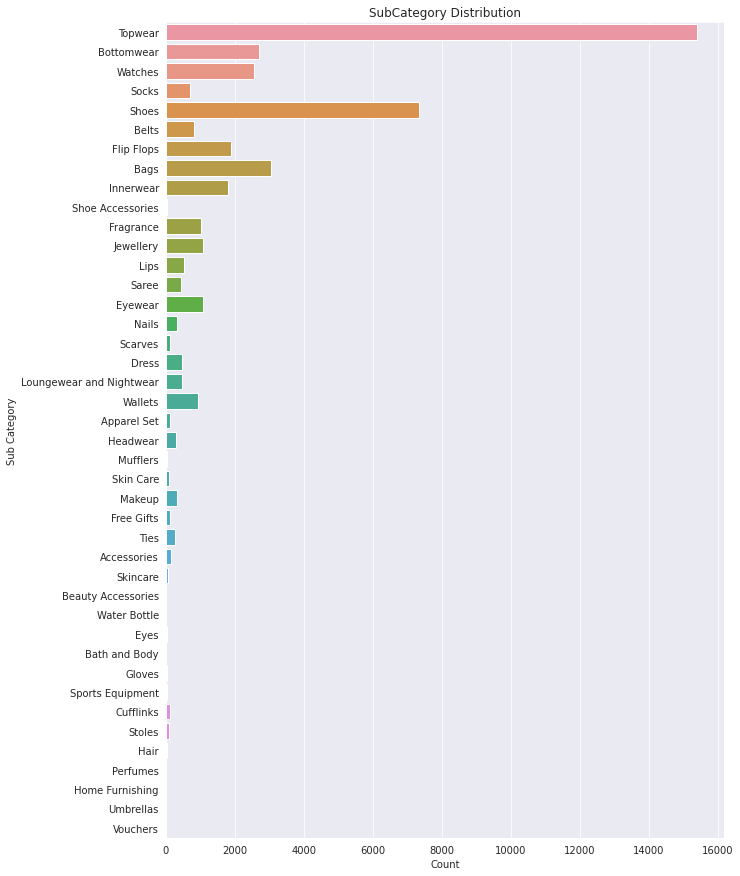

In [ ]:
#Visualization of SubCategory Distribution
fig = plt.figure(figsize=(10,15))
sns.countplot(y='subCategory', data=product)
plt.title("SubCategory Distribution")
plt.xlabel("Count")
plt.ylabel("Sub Category")
plt.show()

From the distribution of the data above, the product category with the most sales is **topwear**, and the product category with the least sales is **Home Furnishing**  and **Vouchers**.

## - How is the distribution of products by year?

In [ ]:
product['year'].unique()

array([2011., 2012., 2016., 2017., 2015., 2014., 2010., 2013., 2018.,
       2019., 2007., 2009., 2008.,    0.])

In [ ]:
# change data type 'year' from float to integer
product['year']=product['year'].astype('int')
product['year'].unique()

array([2011, 2012, 2016, 2017, 2015, 2014, 2010, 2013, 2018, 2019, 2007,
       2009, 2008,    0])

In [ ]:
df_count_y = product.groupby('year').agg(count_of_year=('year','count'))
df_count_y

,count_of_year
year,
0,1
2007,2
2008,7
2009,20
2010,846
2011,13672
2012,16288
2013,1212
2014,236


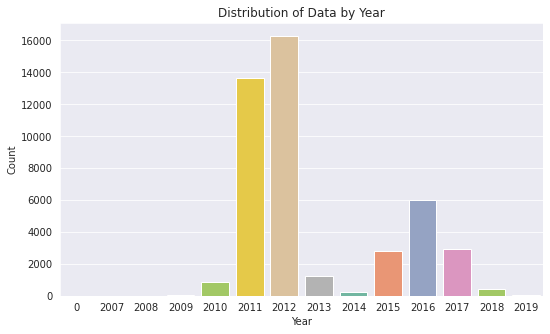

In [ ]:
# distribution of data by year
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
sns.countplot(x = product['year'], palette = 'Set2', ax=ax)
ax.set_title('Distribution of Data by Year')
plt.xlabel('Year')
plt.ylabel("Count")

fig.tight_layout(pad=2)
plt.show()

From the distribution of the data above, the highest production of a product was in **2012**, followed by the second highest production in **2011**, and followed by the third highest production in **2016**.

## - How is the distribution of products by Season?

In [ ]:
product['season'].unique()

array(['Fall', 'Summer', 'Winter', 'Spring', 'none'], dtype=object)

In [ ]:
df_count_season = product.groupby('season').agg(count_of_season=('season','count'))
df_count_season

,count_of_season
season,
Fall,11431
Spring,2983
Summer,21472
Winter,8517
none,21


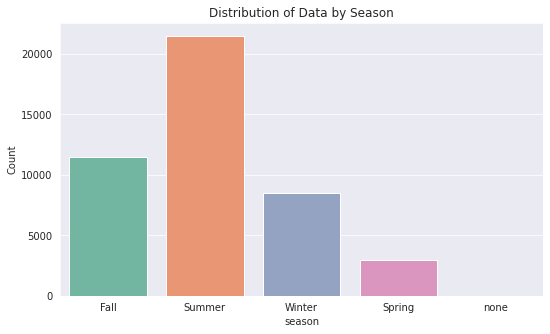

In [ ]:
# distribution of data by season
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121)
sns.countplot(x = product['season'], palette = 'Set2', ax=ax)
ax.set_title('Distribution of Data by Season')
plt.xlabel('season')
plt.ylabel("Count")

fig.tight_layout(pad=2)
plt.show()

From the distribution of the data above, the most offered products are products for the **summer** season, followed by products for the **fall** season, and followed by products for the **winter** season.

## - How is the distribution of products by Usage?

In [ ]:
product['usage'].unique()

array(['Casual', 'Ethnic', 'Formal', 'Sports', 'none', 'Smart Casual',
       'Travel', 'Party', 'Home'], dtype=object)

In [ ]:
df_count_usg = product.groupby('usage').agg(count_of_usage=('usage','count'))
df_count_usg

,count_of_usage
usage,
Casual,34406
Ethnic,3208
Formal,2345
Home,1
Party,29
Smart Casual,67
Sports,4025
Travel,26
none,317


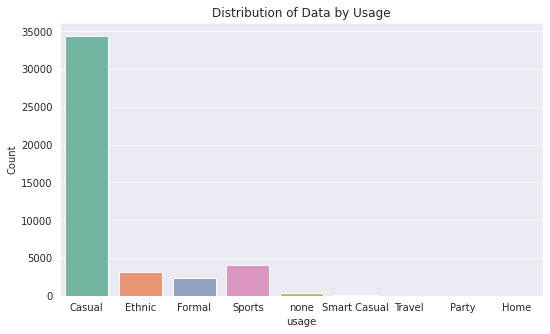

In [ ]:
# distribution of data by usage
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121)
sns.countplot(x = product['usage'], palette = 'Set2', ax=ax)
ax.set_title('Distribution of Data by Usage')
plt.xlabel('usage')
plt.ylabel("Count")

fig.tight_layout(pad=2)
plt.show()

From the distribution of the data above, the most offered products are **casual** themed products.

## - *How is the distribution of payment methods used by customers?*

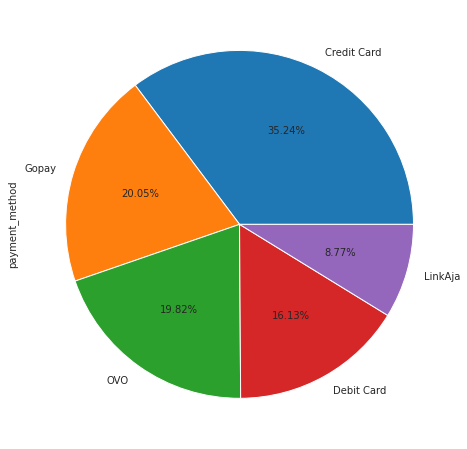

In [ ]:
# payment method visualization
mergedata['payment_method'].value_counts().plot.pie(autopct='%1.2f%%', figsize=(8, 8))

From the visualization above, the most widely used payment method is **Credit Card** at 35.24%, and the least payment method is **Link Aja** at 8.77%.

## - *How is the distribution of customer payment status?*

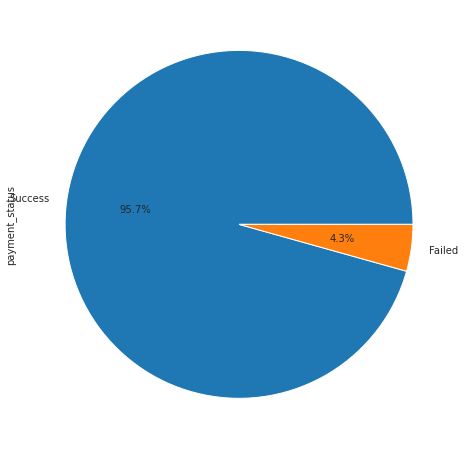

In [ ]:
mergedata['payment_status'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8))

From the visualization above, there are 95.7% of successful customer payment statuses, while 4.3% of failed payment statuses

## - *How is the distribution of Promo Code?*

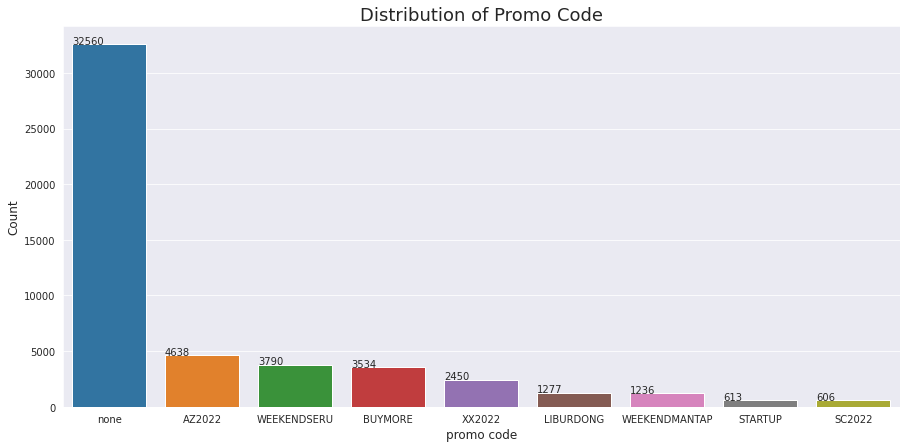

none             32560
AZ2022            4638
WEEKENDSERU       3790
BUYMORE           3534
XX2022            2450
LIBURDONG         1277
WEEKENDMANTAP     1236
STARTUP            613
SC2022             606
Name: promo_code, dtype: int64


In [ ]:
promocode_count=mergedata["promo_code"].value_counts()
plt.figure(figsize=(15,7))
ax=sns.barplot(promocode_count.index, promocode_count.values)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()+10), size = 10)

plt.title('Distribution of Promo Code', fontsize=18)
plt.ylabel('Count', fontsize=12)
plt.xlabel('promo code', fontsize=12)
plt.show()

print(promocode_count)

From the distribution of the data above, the most frequently used promo code is **AZ2022** and the least used is **SC2022**

## - *How is the distribution of Shipment Fee?*

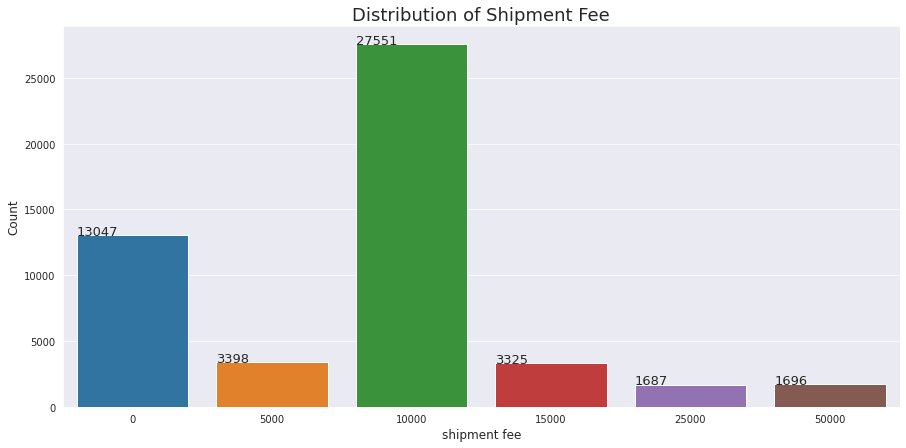

In [ ]:
sf_count=mergedata["shipment_fee"].value_counts()
plt.figure(figsize=(15,7))
ax=sns.barplot(sf_count.index, sf_count.values)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()+10), size = 13)

plt.title('Distribution of Shipment Fee', fontsize=18)
plt.ylabel('Count', fontsize=12)
plt.xlabel('shipment fee', fontsize=12)
plt.show()

From the distribution of the data above, the most postage charged to customers is 10000, and the minimum postage is 25000

# **INSIGHT**
##Click Stream Dataset
1. Event name paling banyak adalah **Booking**, sedangkan paling rendah adalah **Promo Page**.
2. Traffic source antara WEB dan Mobile berselisih jauh dimana Mobile unggul daripada WEB.
3. Laki-laki dan Perempuan lebih banyak menggunakan melalui Mobile ketimbang Web dan terdapat perbedaaan signifikan antara jumlah pengguna mobile olehh laki-laki dan perempuan, akan tetapi selisih antara jumlah pengguna web oleh laki-laki dan perempuan sangat sedikit atau tidak signifikan.
4. Transaksi penjualan paling banyak terjadi pada tahun 2022 sebanyak 32829 transaksi, sementara jumlah transaksi paling sedikit terjadi pada tahun 2016 sebanyak 403 transaksi.
5. Transaksi dari tahun 2016 hingga tahun 2022 selalu mengalami peningkatan, dan peningkatan paling drastis terjadi pada tahun 2022.


##Customer Dataset
1. sekitar 32547 dari data Customer, penggunanya berjenis kelamin perempuan dan disusul dengan jenis kelamin laki-laki sebanyak 18157 customer.
2. Pengguna aplikasi e-commerce terbanyak terdapat pada Provinsi DKI Jakarta atau Jakarta Raya, dan disusul dengan Jawa Barat dan Jawa Tengah.
3. Jenis device yang dipakai oleh pengguna aplikasi didominasi oleh tipe Android dibanding dengan tipe iOS.

##Product Dataset
1. Sasaran produk yang paling banyak dijual diperuntukkan kepada **Men** atau laki-laki dewasa, dan paling sedikit diperuntukkan kepada **Girls** atau anak perempuan.
2. Kategori umum dari produk yang paling banyak dijual adalah **Apparel** atau pakaian dengan jumlah 21 ribu produk, dan yang paling sedikit adalah produk berkategori **Home** yaitu hanya 1 produk.
3. Untuk kategori khusus yang paling banyak dijual adalah **Topwear** dengan total sekitar 15 ribu produk, sementara kategori khusus yang paling sedikit adalah **Home Furnishing** dan **Vouchers**.
4. Produksi produk paling banyak yaitu pada tahun 2012, dan produksi paling sedikit tahun 2016.
5. Produk yang dijual paling banyak adalah produk yang cocok digunakan pada musim panas atau **Summer**.
6. Sedangkan produk terbanyak yang dijual bertemakan **Casual** atau cocok untuk saat-saat santai.

##Transaction Dataset
1. Metode pembayaran yang paling banyak digunakan oleh pelanggan adalah metode **Credit Card** sebesar 35,24%, dan metode pembayaran paling sedikit adalah **Link Aja** sebesar 8.77%.
2. Sebesar 95.7% status pembayaran pelanggan **Successful** , sementara 4.3% status pembayaran pelanggan **Failed**.
3. Kode promo yang paling sering digunakan adalah **AZ2022**, sedangkan kode promo yang sedikit digunakan adalah **SC2022**.
4. Ongkir yang paling banyak dikenakan kepada pelanggan sejumlah Rp 10000, dan paling sedikit sejumlah Rp 25000.

# **Features Engineering**

In [ ]:
# mergedata.drop(columns=['promo_amount','shipment_fee'],axis=1, inplace=True)

In [ ]:
#create new columns for delivery time
mergedata['delivery_time'] = mergedata['shipment_date_limit'] - mergedata['created_at']
mergedata[['delivery_time']]

,delivery_time
0,4 days 17:29:25.169744
1,3 days 19:59:46.374372
2,5 days 22:11:16.337946
3,6 days 00:36:31.984442
4,2 days 00:17:52.273514
...,...
50699,4 days 17:33:32.978327
50700,4 days 01:23:41.191417
50701,3 days 21:35:39.535768
50702,4 days 14:57:11.798723


In [ ]:
mergedata['delivery_time']=mergedata['delivery_time'].dt.days
mergedata[['delivery_time']]

,delivery_time
0,4
1,3
2,5
3,6
4,2
...,...
50699,4
50700,4
50701,3
50702,4


In [ ]:
mergedata.head()

,session_id,event_name,event_time,traffic_source,created_at,customer_id,payment_method,payment_status,promo_amount,promo_code,...,device_type,device_version,home_location,first_join_date,total_promo_amount,number_of_promo,transaction_failed,number_of_transaction,total_shipment_fee,delivery_time
0,8f385c80-1b70-4861-80ac-5eb3b5620fee,HOMEPAGE,2016-07-01 21:58:10.392355+00:00,MOBILE,2016-07-01 22:32:45.218400+00:00,73773,Debit Card,Success,0,none,...,Android,Android 4.3,Jawa Barat,2016-06-30,0,0.0,0.0,1.0,10000,4
1,54a40fd2-7446-40b6-97a4-b51600d5df54,CLICK,2016-07-02 19:34:00.632760+00:00,MOBILE,2016-07-02 20:01:04.996529+00:00,30771,Credit Card,Success,5272,WEEKENDSERU,...,iOS,iPad; CPU iPad OS 6_1_6 like Mac OS X,Maluku,2016-07-02,5272,1.0,0.0,1.0,5000,3
2,2a6aa94f-0b0d-42ce-8615-619cc437dd0c,CLICK,2016-07-03 16:17:42.174433+00:00,MOBILE,2016-07-03 16:25:01.401472+00:00,67563,Gopay,Success,0,none,...,Android,Android 2.3.4,Jakarta Raya,2016-07-03,0,0.0,0.0,1.0,10000,5
3,8bcd8c49-fe5d-4121-b967-b3964b537c30,CLICK,2016-07-04 00:48:05.275874+00:00,MOBILE,2016-07-04 00:58:13.525069+00:00,22844,Gopay,Success,5952,AZ2022,...,Android,Android 5.0,Jakarta Raya,2016-07-02,5952,1.0,0.0,1.0,10000,6
4,2cb5c61d-a740-472f-92c8-c777e636fc6a,HOMEPAGE,2016-07-04 18:05:59.034764+00:00,MOBILE,2016-07-04 18:10:42.766218+00:00,9914,Credit Card,Success,6060,AZ2022,...,iOS,iPhone; CPU iPhone OS 7_1_2 like Mac OS X,Sumatera Utara,2016-07-04,6060,1.0,0.0,1.0,15000,2


#  **EDA Customer Churn**

In [ ]:
# created a function for customer churn
# jika waktu terakhir transaksi pelanggan lebih dari 1 bulan (30 hari)pelanggan tersebut churn dan sebaliknya (no churn)
now = '2022-07-31 23:59:45.821469+0000'
def churn(c):
    try:
        last_transaction = pd.to_datetime(c)
        delta_time = pd.Timestamp(now)  - last_transaction
        day = delta_time.days
        if day > 30:
            return 1
        else:
            return 0
    except:
        return 1

mergedata['churn'] = mergedata.created_at.apply(lambda c: churn(c))

In [ ]:
mergedata['churn'].unique()

array([1, 0])

In [ ]:
# view total customer churn/no churn
Numcuschurned = mergedata[mergedata.churn == 1].shape[0]
Numcusstayed =  mergedata[mergedata.churn == 0].shape[0]
print('Customer Churned:', Numcuschurned)
print('Customers Stayed:', Numcusstayed)

Customer Churned: 40481
Customers Stayed: 10223


In [ ]:
mergedata['created_at'].max()

Timestamp('2022-07-31 23:59:45.821469+0000', tz='UTC')

In [ ]:
a = mergedata[mergedata['created_at']>'2022-06-30 23:59:45.218400+0000']
b = mergedata[mergedata['created_at']<'2022-06-30 23:59:45.218400+0000']
print(len(a))
print(len(b))

10223
40481


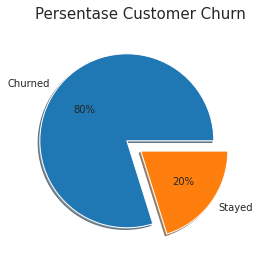

1    40481
0    10223
Name: churn, dtype: int64


In [ ]:
churn_count=mergedata["churn"].value_counts()
fig = plt.figure()
myexplode = [0.2, 0]
labels = ['Churned','Stayed']
churn = mergedata.churn.value_counts()
plt.pie(churn, labels = labels, explode = myexplode, shadow = True, autopct='%.0f%%')
plt.title('Persentase Customer Churn\n', fontsize=15)
plt.show()
print(churn_count)

    Keterangan:
    ➡ 0 : no churn
    ➡ 1 : churn

**From the data visualization above, it can be concluded that the majority of the data distribution do not do Churn, with details of Stayed as much as 20% and Churned as much as 80%.**

**EDA of numeric variable**

In [ ]:
# cek deskripsi variabel numerik
mergedata.describe()

,customer_id,promo_amount,shipment_fee,total_amount,total_promo_amount,number_of_promo,transaction_failed,number_of_transaction,total_shipment_fee,delivery_time,churn
count,50704.000000,50704.000000,50704.000000,5.070400e+04,5.070400e+04,50704.000000,50704.000000,50704.000000,5.070400e+04,50704.000000,50704.000000
mean,49810.841255,1902.193791,9256.666141,5.491983e+05,3.433730e+04,6.440024,0.722231,16.092655,1.545232e+05,3.039879,0.798379
std,28957.892213,2991.666968,9460.459857,8.013646e+05,6.963247e+04,12.998535,2.311415,28.574328,2.751810e+05,1.425156,0.401215
min,3.000000,0.000000,0.000000,1.757300e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,24693.750000,0.000000,0.000000,2.040758e+05,2.277750e+03,1.000000,0.000000,2.000000,1.500000e+04,2.000000,1.000000
50%,49711.000000,0.000000,10000.000000,3.034405e+05,1.036950e+04,2.000000,0.000000,6.000000,5.500000e+04,3.000000,1.000000
75%,74863.500000,3732.000000,10000.000000,5.172312e+05,3.427300e+04,6.000000,1.000000,17.000000,1.700000e+05,4.000000,1.000000
max,99999.000000,23839.000000,50000.000000,1.462553e+07,1.940716e+06,348.000000,83.000000,550.000000,4.810000e+06,6.000000,1.000000


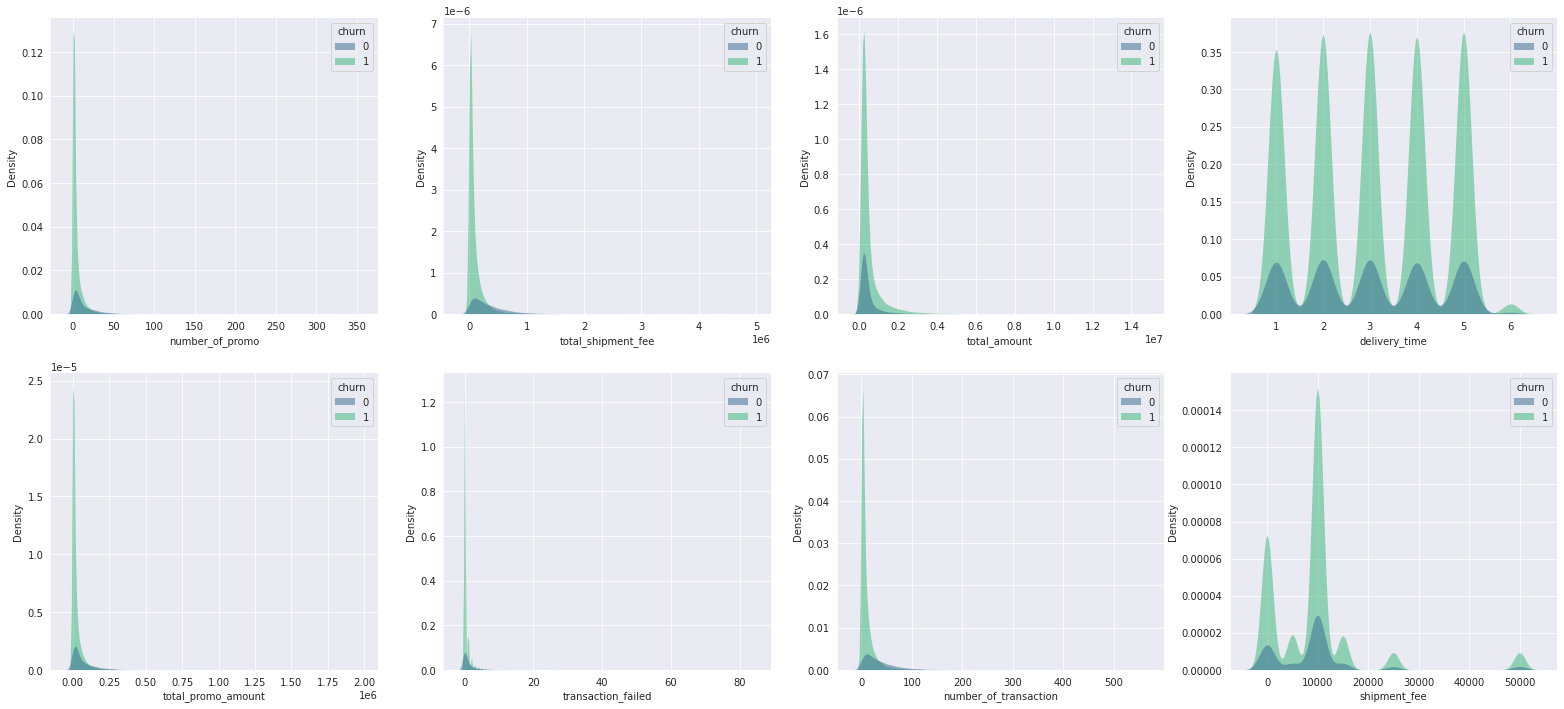

In [ ]:
# visualisasi sebaran churn pada variabel numerik
fig = plt.figure(figsize=(27,12))
gs = fig.add_gridspec(2,4)
ax_promo_amount= fig.add_subplot(gs[0,0])
sns.kdeplot(x='number_of_promo', hue='churn', data=mergedata, fill=True, alpha=.5, linewidth=0, ax=ax_promo_amount, palette='viridis', shade=True)
sns.despine()
ax_shipment_fee = fig.add_subplot(gs[0,1])
sns.kdeplot(x='total_shipment_fee', hue='churn', data=mergedata, fill=True, alpha=.5, linewidth=0, ax=ax_shipment_fee, palette='viridis', shade=True)
sns.despine()
ax_total_amount = fig.add_subplot(gs[0,2])
sns.kdeplot(x='total_amount', hue='churn', data=mergedata, fill=True, alpha=.5, linewidth=0, ax=ax_total_amount, palette='viridis', shade=True)
sns.despine()
ax_total_amount = fig.add_subplot(gs[0,3])
sns.kdeplot(x='delivery_time', hue='churn', data=mergedata, fill=True, alpha=.5, linewidth=0, ax=ax_total_amount, palette='viridis', shade=True)
sns.despine()
ax_total_amount = fig.add_subplot(gs[1,0])
sns.kdeplot(x='total_promo_amount', hue='churn', data=mergedata, fill=True, alpha=.5, linewidth=0, ax=ax_total_amount, palette='viridis', shade=True)
sns.despine()
ax_total_amount = fig.add_subplot(gs[1,1])
sns.kdeplot(x='transaction_failed', hue='churn', data=mergedata, fill=True, alpha=.5, linewidth=0, ax=ax_total_amount, palette='viridis', shade=True)
sns.despine()
ax_total_amount = fig.add_subplot(gs[1,2])
sns.kdeplot(x='number_of_transaction', hue='churn', data=mergedata, fill=True, alpha=.5, linewidth=0, ax=ax_total_amount, palette='viridis', shade=True)
sns.despine()
sns.despine()
ax_total_amount = fig.add_subplot(gs[1,3])
sns.kdeplot(x='shipment_fee', hue='churn', data=mergedata, fill=True, alpha=.5, linewidth=0, ax=ax_total_amount, palette='viridis', shade=True)
sns.despine()

Dari visualisasi di atas, dapat dilihat bahwa semakin banyak jumlah promo dan ongkir yang diberikan kepada pelanggan, maka semakin kecil pula kemungkinan pelanggan melakukan churn.

**EDA of categorical variabel**

In [ ]:
# cek deskripsi variabel katerogi
mergedata.describe(include='O')

,session_id,event_name,traffic_source,payment_method,payment_status,promo_code,gender,device_type,device_version,home_location
count,50704,50704,50704,50704,50704,50704,50704,50704,50704,50704
unique,50704,9,2,5,2,9,2,2,86,33
top,8f385c80-1b70-4861-80ac-5eb3b5620fee,HOMEPAGE,MOBILE,Credit Card,Success,none,F,Android,Android 4.4.3,Jakarta Raya
freq,1,11779,45583,17868,48501,32560,32547,38932,678,9389


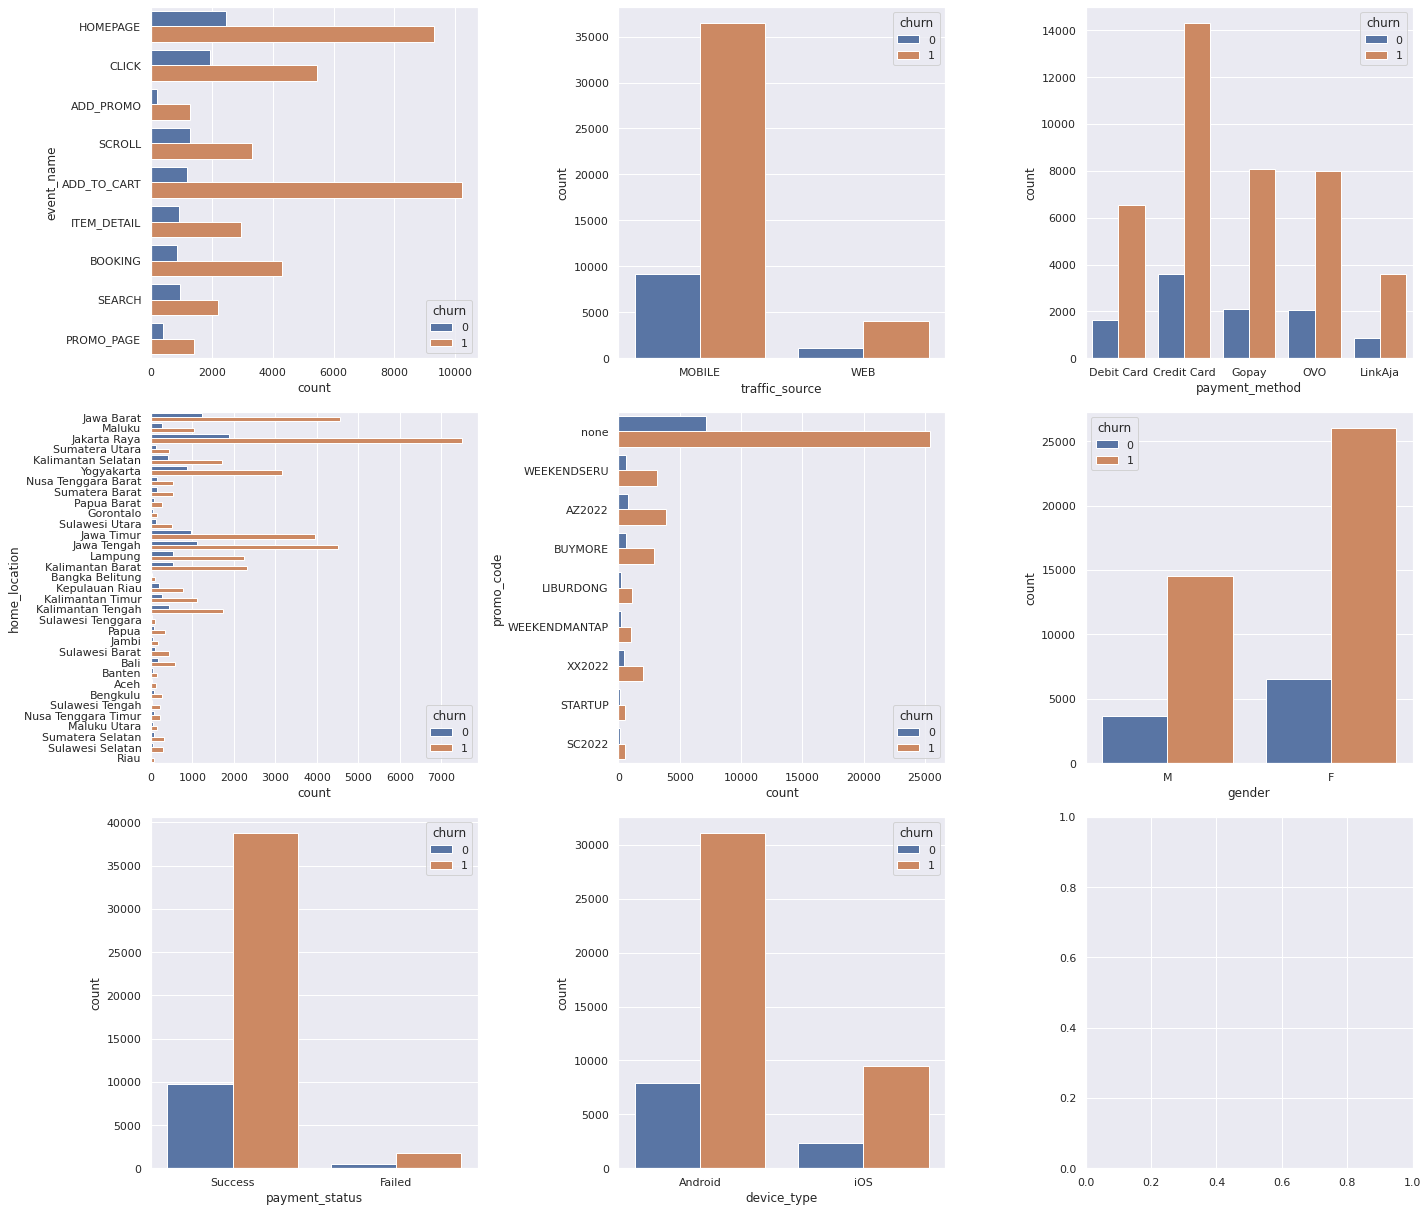

In [ ]:
# visualisasi sebaran churn pada variabel kategorikal
sns.set(style='darkgrid')
fig, ax = plt.subplots(3, 3, figsize=(20, 17))
sns.countplot(data=mergedata, y='event_name', hue='churn', ax=ax[0][0])
sns.countplot(data=mergedata, x='traffic_source', hue='churn', ax=ax[0][1])
sns.countplot(data=mergedata, x='payment_method', hue='churn', ax=ax[0][2])
sns.countplot(data=mergedata, y='home_location', hue='churn', ax=ax[1][0])
sns.countplot(data=mergedata, y='promo_code', hue='churn', ax=ax[1][1])
sns.countplot(data=mergedata, x='gender', hue='churn', ax=ax[1][2])
sns.countplot(data=mergedata, x='payment_status', hue='churn', ax=ax[2][0])
sns.countplot(data=mergedata, x='device_type', hue='churn', ax=ax[2][1])
plt.tight_layout()
plt.show()

In [ ]:
mergedata.to_csv('outputdata.csv', index=True)

## **INSIGHT**
1. Dari hasil eksplorasi data churn, didapatkan mayoritas pelanggan masih berlangganan atau tidak churn yaitu sebanyak 35577 (70%), dan jumlah Customer churn atau yang berhenti berlangganan sebanyak 15127 (30%).
2. Customer yang paling banyak melakukan Churn adalah  **Female** (perempuan)
3. Tipe Device yang paling banyak churn adalah **Android** dan jenis media aplikasi yang paling banyak churn berbasis **Mobile**
4. Customer yang paling banyak churn bertempat tinggal di **Jakarta Raya**
5. Metode pembayaran yang paling banyak churn adalah **Credit Card**
5. Kode promo yang paling banyak churn adalah **WEEKENDSERU**

# **Data Labeling**

In [ ]:
df = mergedata.copy()
df.head()

,session_id,event_name,event_time,traffic_source,created_at,customer_id,payment_method,payment_status,promo_amount,promo_code,...,device_version,home_location,first_join_date,total_promo_amount,number_of_promo,transaction_failed,number_of_transaction,total_shipment_fee,delivery_time,churn
0,8f385c80-1b70-4861-80ac-5eb3b5620fee,HOMEPAGE,2016-07-01 21:58:10.392355+00:00,MOBILE,2016-07-01 22:32:45.218400+00:00,73773,Debit Card,Success,0,none,...,Android 4.3,Jawa Barat,2016-06-30,0,0.0,0.0,1.0,10000,4,1
1,54a40fd2-7446-40b6-97a4-b51600d5df54,CLICK,2016-07-02 19:34:00.632760+00:00,MOBILE,2016-07-02 20:01:04.996529+00:00,30771,Credit Card,Success,5272,WEEKENDSERU,...,iPad; CPU iPad OS 6_1_6 like Mac OS X,Maluku,2016-07-02,5272,1.0,0.0,1.0,5000,3,1
2,2a6aa94f-0b0d-42ce-8615-619cc437dd0c,CLICK,2016-07-03 16:17:42.174433+00:00,MOBILE,2016-07-03 16:25:01.401472+00:00,67563,Gopay,Success,0,none,...,Android 2.3.4,Jakarta Raya,2016-07-03,0,0.0,0.0,1.0,10000,5,1
3,8bcd8c49-fe5d-4121-b967-b3964b537c30,CLICK,2016-07-04 00:48:05.275874+00:00,MOBILE,2016-07-04 00:58:13.525069+00:00,22844,Gopay,Success,5952,AZ2022,...,Android 5.0,Jakarta Raya,2016-07-02,5952,1.0,0.0,1.0,10000,6,1
4,2cb5c61d-a740-472f-92c8-c777e636fc6a,HOMEPAGE,2016-07-04 18:05:59.034764+00:00,MOBILE,2016-07-04 18:10:42.766218+00:00,9914,Credit Card,Success,6060,AZ2022,...,iPhone; CPU iPhone OS 7_1_2 like Mac OS X,Sumatera Utara,2016-07-04,6060,1.0,0.0,1.0,15000,2,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50704 entries, 0 to 50703
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   session_id             50704 non-null  object             
 1   event_name             50704 non-null  object             
 2   event_time             50704 non-null  datetime64[ns, UTC]
 3   traffic_source         50704 non-null  object             
 4   created_at             50704 non-null  datetime64[ns, UTC]
 5   customer_id            50704 non-null  int64              
 6   payment_method         50704 non-null  object             
 7   payment_status         50704 non-null  object             
 8   promo_amount           50704 non-null  int64              
 9   promo_code             50704 non-null  object             
 10  shipment_fee           50704 non-null  int64              
 11  shipment_date_limit    50704 non-null  datetime64[ns, 

In [ ]:
df.drop(columns=['promo_amount','traffic_source','device_type','promo_code','payment_status','payment_method','session_id','created_at','customer_id','shipment_date_limit','event_time','total_amount','birthdate','first_join_date'],axis=1, inplace=True)

In [ ]:
df.nunique().sort_values(ascending=False)

total_promo_amount       28338
total_shipment_fee         498
number_of_transaction      297
number_of_promo            158
device_version              86
transaction_failed          50
home_location               33
event_name                   9
shipment_fee                 6
delivery_time                6
gender                       2
churn                        2
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50704 entries, 0 to 50703
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   event_name             50704 non-null  object 
 1   shipment_fee           50704 non-null  int64  
 2   gender                 50704 non-null  object 
 3   device_version         50704 non-null  object 
 4   home_location          50704 non-null  object 
 5   total_promo_amount     50704 non-null  int64  
 6   number_of_promo        50704 non-null  float64
 7   transaction_failed     50704 non-null  float64
 8   number_of_transaction  50704 non-null  float64
 9   total_shipment_fee     50704 non-null  int64  
 10  delivery_time          50704 non-null  int64  
 11  churn                  50704 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.0+ MB


In [ ]:
df.head()

,event_name,shipment_fee,gender,device_version,home_location,total_promo_amount,number_of_promo,transaction_failed,number_of_transaction,total_shipment_fee,delivery_time,churn
0,HOMEPAGE,10000,M,Android 4.3,Jawa Barat,0,0.0,0.0,1.0,10000,4,1
1,CLICK,5000,F,iPad; CPU iPad OS 6_1_6 like Mac OS X,Maluku,5272,1.0,0.0,1.0,5000,3,1
2,CLICK,10000,F,Android 2.3.4,Jakarta Raya,0,0.0,0.0,1.0,10000,5,1
3,CLICK,10000,F,Android 5.0,Jakarta Raya,5952,1.0,0.0,1.0,10000,6,1
4,HOMEPAGE,15000,M,iPhone; CPU iPhone OS 7_1_2 like Mac OS X,Sumatera Utara,6060,1.0,0.0,1.0,15000,2,1


**Encoding Data**

In [ ]:
from sklearn.preprocessing import LabelEncoder
#konversi semua variabel tipe non-numerikal ke tipe numerikal
for col in df.columns:
    if df[col].dtype == np.number: continue
    #terapkan encoding pada tiap variabel non-numerikal
    df[col] = LabelEncoder().fit_transform(df[col])

In [ ]:
# One Hot Encoding semua features
# df = pd.get_dummies(df)

In [ ]:
df.head()

,event_name,shipment_fee,gender,device_version,home_location,total_promo_amount,number_of_promo,transaction_failed,number_of_transaction,total_shipment_fee,delivery_time,churn
0,4,2,1,41,8,0,0.0,0.0,1.0,2,3,1
1,3,1,0,70,17,3070,1.0,0.0,1.0,1,2,1
2,3,2,0,17,6,0,0.0,0.0,1.0,2,4,1
3,3,2,0,48,6,3638,1.0,0.0,1.0,2,5,1
4,4,3,1,83,31,3725,1.0,0.0,1.0,3,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50704 entries, 0 to 50703
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   event_name             50704 non-null  int64  
 1   shipment_fee           50704 non-null  int64  
 2   gender                 50704 non-null  int64  
 3   device_version         50704 non-null  int64  
 4   home_location          50704 non-null  int64  
 5   total_promo_amount     50704 non-null  int64  
 6   number_of_promo        50704 non-null  float64
 7   transaction_failed     50704 non-null  float64
 8   number_of_transaction  50704 non-null  float64
 9   total_shipment_fee     50704 non-null  int64  
 10  delivery_time          50704 non-null  int64  
 11  churn                  50704 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 5.0 MB


## Define Predictor Variables & Predictive Variables (Churn)

In [ ]:
X = df.drop(columns=['churn'], axis=1)
y = df['churn']

# **Build a Model**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)

In [ ]:
clf.fit(X_train, y_train)

ExtraTreesClassifier(random_state=0)

In [ ]:
clf.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
confusion_matrix(list(y_test), clf.predict(X_test))

array([[ 995,  993],
       [ 516, 7637]])

In [ ]:
confusion_matrix(list(y_test), clf.predict(X_test))

array([[ 995,  993],
       [ 516, 7637]])

In [ ]:
accuracy_score(list(y_test), clf.predict(X_test))

0.8511981066955921

# **Feature Selection & Correlation Analysis**

###Correlation Analysis

Text(0.5, 1.0, 'Correlation Matrix antara variable X')

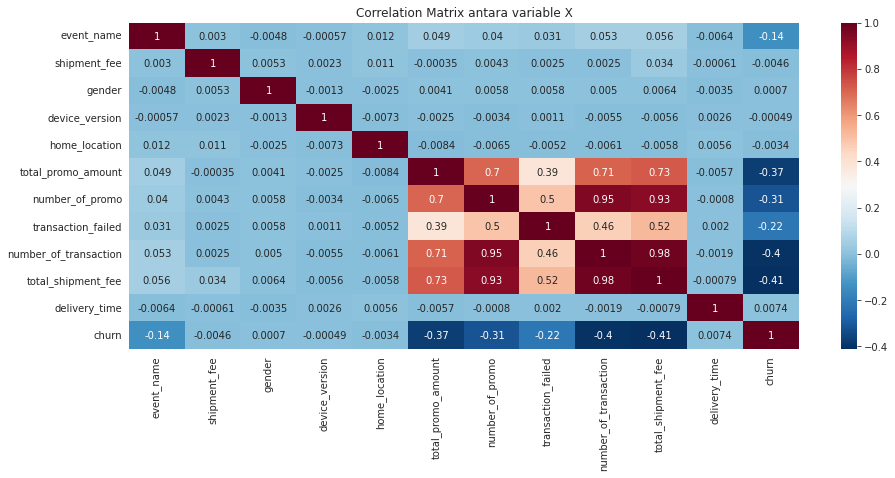

In [ ]:
#Atau Jika menggunakan heatmap
plt.figure(figsize=(15,6))
sns.heatmap(df.corr(), cmap="RdBu_r", annot=True)
plt.title('Correlation Matrix antara variable X')

1. Hampir semua kotak cenderung berwarna biru terang (nilai koefisien mendekati 0)), itu menandakan bahwa hampir semua fitur tidak memiliki hubungan signifikan dengan kolom Churn.
2. Terdapat beberapa variabel yang saling berkorelasi, yaitu **total shipment feet** dan **number of transaction** dengan nilai korelasi sebesar 0.98 (korelasi positif), **number of transaction** dan **number of promo** dengan nilai korelasi sebesar 0.95 (korelasi positif), **number of promo** dan **total shipment feet** dengan nilai korelasi 0.93 (korelasi positif) .

    (**total shipment feet** tidak dimasukkan kedalam model karena memiliki hubungan multikolinearitas paling tinggi)

3. Variabel yang paling berkorelasi negatif dengan **churn** adalah **number of transaction** (-0.4)
4. Variabel yang paling berkorelasi positif dengan **churn** adalah **delivey time** (0.0074)

In [ ]:
X = df.drop(columns=['churn','total_shipment_fee'], axis=1)
y = df['churn']

### Features Selection

In [ ]:
# feature selection
# import library
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Features','Score']
print('The features that correlate well with target feature:\n')
featureScores.sort_values(by='Score',ascending=False)

The features that correlate well with target feature:



,Features,Score
5,total_promo_amount,5.921728e+07
8,number_of_transaction,4.108033e+05
6,number_of_promo,1.302990e+05
7,transaction_failed,1.741387e+04
0,event_name,1.353473e+03
4,home_location,2.914299e+00
9,delivery_time,2.742382e+00
1,shipment_fee,9.764781e-01
3,device_version,1.794584e-01
2,gender,1.598714e-02


### Data Splitting

In [ ]:
# define x and y features (top 8 features)
X = df[['total_promo_amount','number_of_transaction','number_of_promo','transaction_failed','event_name','home_location','delivery_time','shipment_fee']]
y = df['churn']

In [ ]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(40563, 8) (10141, 8)


**Hubungan variabel X dengan customer churn**


💲  **total promo amount** - churn** : semakin banyak promo yang ditawarkan kepada  pelanggan, maka semakin tertarik pelanggan dalam membeli produk. Sebaliknya, toko yang cukup jarang bahkan tidak pernah menawarkan promo pada suatu produk,pelanggan akan sulit tertarik dan biasanya pelanggan akan mempertimbangkkan harga dalam berbelanja, sehingga lebih mencari toko yang lebi banyak menawarkan promo. Hal ini, sangat dapat berpengaruh terhadap customer churn.

🏦 **number of transaction** - **churn** : seberapa sering pelanggan melakukan transaksi. Semakin banyak transaksi maka dapat dikatakan bahwa pelanggan tersebut betah dan suka berbelanja di toko.

💐 **number of promo** - **churn** : berapa kali pelanggan mendapatkan promo selama bertransaksi. Semakin sering mendapatkan promo pelanggan akan merasa diuntungkan, dan hemat. Sebaliknya , jika sedikit mendapatkan promo, pelanggan cenderung kurang antusias untuk berbelanja. Hal ini dapat berpengaruh terhadap prilaku churn.

❌ **Transaction failed** - **churn** :  sebesarpa sering pelanggan membatalkan transaksinya. Hal ini dapat terjadi karena banyak hal dan dapat memicu pelanggan melakukan churn.

📆 **event name** - **Churn** : aktivitas pelanggan saat membuka aplikasi. Aktivitas seperti **Click**, **Scroll** atau aktivitas lainnya yang tidak melakukan transaksi dapat menjadi probabilitas pelanggan melakukan churn atau tidak.

💟**Home Location** - **Churn** : Tempat tinggal pelanggan yang jauh dari lokasi toko akan mempengaruhi durasi pengiriman barang sampai kepada pelanggan serta biaya pengiriman yang lebih besar.Hal tersebut dapat mempengaruhi pelanggan melakukan churn untuk berpindah ke toko yang lebih dekat dengan lokasi toko.

⏰ **delivery_time** - **Churn** : waktu pengiriman yang lama akan membuat pelanggan jenuh dalam menunggu barang sampai kepada pelanggan. Hal tersebut biasanya akan menjadi faktor pertimbangan pelanggan selanjutnya dalam membeli barang sehingga hal itu dapat mempengaruhi customer churn.

🏧 **shipment fee** - **churn** : biaya pengiriman yang cenderung mahal akan membuat pelanggan merasa rugi, dan boros dalam berbelanja. Oleh karena itu, pelanggan akan memilihi toko yang memberikan biaya pengiriman lebih murah atau gratis biaya pengiriman barang.


### Features Scaling

In [ ]:
# normalize features
scaler = StandardScaler()
# Scaling X train
X_train = scaler.fit_transform(X_train)
# Scaling X test
X_test = scaler.fit_transform(X_test)

In [ ]:
X_train

array([[-0.25696676, -0.529142  , -0.42033445, ...,  0.37152846,
         2.07887164, -0.53549585],
       [ 2.15166985, 12.3214494 , 11.90823317, ...,  0.37152846,
         0.67610404,  0.28837361],
       [ 1.59023112,  0.86387603,  0.95801473, ..., -0.86152932,
        -1.42804737, -1.35936531],
       ...,
       [-0.54757659, -0.21571295, -0.42033445, ...,  0.49483424,
        -0.02527977,  0.28837361],
       [-1.04922046, -0.529142  , -0.4969094 , ...,  0.98805735,
        -0.02527977, -0.53549585],
       [-0.13805524, -0.4594911 , -0.42033445, ...,  0.98805735,
         0.67610404,  0.28837361]])

In [ ]:
X_test

array([[ 0.43664685, -0.31023251, -0.09751256, ..., -0.24672274,
        -0.74175887, -0.53824045],
       [-0.07865665, -0.45308463, -0.3327909 , ..., -0.85171724,
        -1.44470033,  0.28453561],
       [ 0.24787343, -0.16738039, -0.17593868, ..., -0.85171724,
        -0.74175887,  0.28453561],
       ...,
       [-0.60366132, -0.31023251, -0.3327909 , ..., -0.85171724,
         0.66412407,  0.28453561],
       [-0.91649563, -0.52451069, -0.41121702, ..., -0.85171724,
        -0.74175887,  0.28453561],
       [-0.01131909, -0.27451948, -0.3327909 , ...,  0.11627397,
         0.66412407, -1.36101651]])

# **Handling Imbalance Data & Outliers**

## Handling Imbalanced Data with SMOTE | Up-sampling

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE

In [ ]:
X_res, y_res = SMOTE().fit_resample(X,y)

In [ ]:
y_res.value_counts()

1    40481
0    40481
Name: churn, dtype: int64

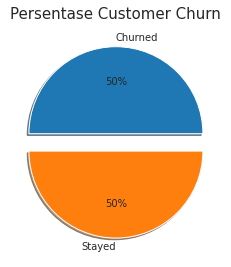

1    40481
0    40481
Name: churn, dtype: int64


In [ ]:
churn_count=y_res.value_counts()
labels = ['Churned','Stayed']
churn = y_res.value_counts()
plt.title('Persentase Customer Churn\n', fontsize=15)
myexplode = [0.2, 0]
plt.pie(churn, labels = labels, explode = myexplode, shadow = True,autopct='%.0f%%')
plt.show()
print(churn_count)

##Handling Outlier

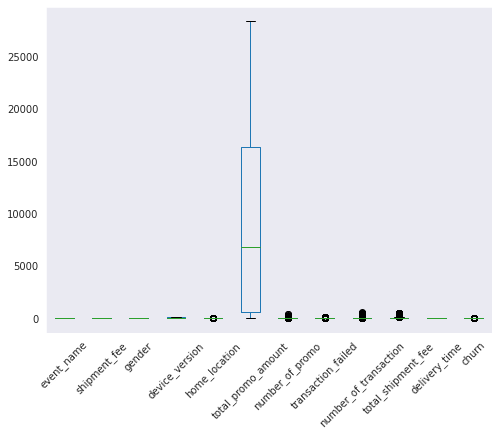

In [ ]:
boxplot = df.boxplot(grid=False, rot=45,  figsize=(8,6))

In [ ]:
# Handling with IQR
Q1 = (df[['home_location','number_of_promo','transaction_failed','number_of_transaction','total_shipment_fee','churn']]).quantile(0.25)
Q3 = (df[['home_location','number_of_promo','transaction_failed','number_of_transaction','total_shipment_fee','churn']]).quantile(0.75)
IQR = Q3 - Q1

maximum = Q3 + (1.5*IQR)
minimum = Q1 - (1.5*IQR)
upper_limit = (df > maximum)
lower_limit = (df < minimum)
df = df.mask(upper_limit, maximum, axis=1)
df = df.mask(lower_limit, minimum, axis=1)

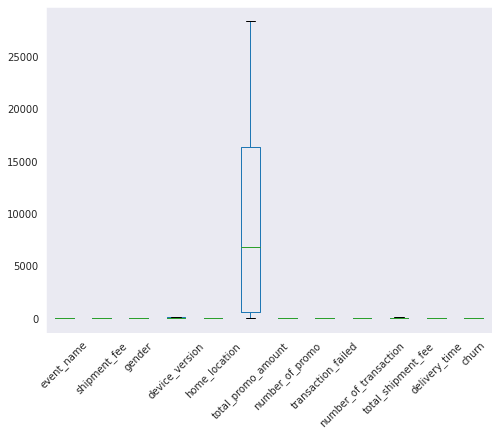

In [ ]:
boxplot = df.boxplot(grid=False, rot=45,  figsize=(8,6))

# **Base Model**

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
#from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, recall_score,confusion_matrix, accuracy_score, precision_score

In [ ]:
# Base Modelling Algorithms
## Collect all model in one list

all_model = [LogisticRegression,
             KNeighborsClassifier,
             DecisionTreeClassifier,
             CatBoostClassifier,
             GradientBoostingClassifier]

model_name = ['LogisticRegression',
             'KNeighborsClassifier',
             'DecisionTreeClassifier',
             'CatBoostClassifier',
             'GradientBoostingClassifier']

## loop for all model
datatr = []
datasc = []
Recall =[]
Recall_tr =[]
Precision =[]
Precision_tr =[]
f1score =[]
f1score_tr =[]
auc =[]
mse = []

for idx, model_type in enumerate(all_model):
    AccTrain = []
    AccTest = []
    RecallTemp = []
    RecalltrainTemp = []
    PrecisionTemp = []
    PrecisiontrainTemp = []
    F1ScoreTemp = []
    F1ScoretrainTemp = []
    AucTemp = []
    msetemp = []

    model = model_type()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_train_pr = model.predict(X_train)

    AccTrain.append(model.score(X_train , y_train))
    AccTest.append(model.score(X_test , y_test))
    RecallTemp.append(recall_score(y_test,y_pred))
    RecalltrainTemp.append(recall_score(y_train,y_train_pr))
    PrecisionTemp.append(precision_score(y_test,y_pred))
    PrecisiontrainTemp.append(precision_score(y_train,y_train_pr))
    F1ScoreTemp.append(f1_score(y_test,y_pred))
    F1ScoretrainTemp.append(f1_score(y_train,y_train_pr))
    AucTemp.append(roc_auc_score(y_test, y_pred))
    msetemp.append(mean_squared_error(y_test, y_pred))

    datatr.append(np.mean(AccTrain))
    datasc.append(np.mean(AccTest))
    Recall.append(np.mean(RecallTemp))
    Recall_tr.append(np.mean(RecalltrainTemp))
    Precision.append(np.mean(PrecisionTemp))
    Precision_tr.append(np.mean(PrecisiontrainTemp))
    f1score.append(np.mean(F1ScoreTemp))
    f1score_tr.append(np.mean(F1ScoretrainTemp))
    auc.append(np.mean(AucTemp))
    mse.append(np.mean(msetemp))

Learning rate set to 0.050073
0:	learn: 0.6577658	total: 53.6ms	remaining: 53.6s
1:	learn: 0.6254693	total: 61.2ms	remaining: 30.6s
2:	learn: 0.5933797	total: 68.4ms	remaining: 22.7s
3:	learn: 0.5685241	total: 76.2ms	remaining: 19s
4:	learn: 0.5442313	total: 83.9ms	remaining: 16.7s
5:	learn: 0.5220441	total: 92.2ms	remaining: 15.3s
6:	learn: 0.5058805	total: 102ms	remaining: 14.4s
7:	learn: 0.4899230	total: 109ms	remaining: 13.6s
8:	learn: 0.4754894	total: 119ms	remaining: 13.1s
9:	learn: 0.4619442	total: 127ms	remaining: 12.5s
10:	learn: 0.4505654	total: 134ms	remaining: 12s
11:	learn: 0.4402049	total: 142ms	remaining: 11.7s
12:	learn: 0.4313853	total: 150ms	remaining: 11.4s
13:	learn: 0.4227623	total: 158ms	remaining: 11.1s
14:	learn: 0.4159398	total: 166ms	remaining: 10.9s
15:	learn: 0.4092231	total: 174ms	remaining: 10.7s
16:	learn: 0.4037023	total: 181ms	remaining: 10.5s
17:	learn: 0.3979812	total: 189ms	remaining: 10.3s
18:	learn: 0.3933483	total: 202ms	remaining: 10.4s
19:	learn

In [ ]:
## compare model each other
result = pd.DataFrame()
result['model'] = model_name
result['Accuracy training'] = datatr
result['Accuracy test'] = datasc
result['Precision training'] = Precision_tr
result['Precision test'] = Precision
result['Recall training']= Recall_tr
result['Recall test']= Recall
result['F1-Score training']= f1score_tr
result['F1-Score test']= f1score
result['AUC']=auc
result['MSE']=mse
result['gap'] = abs(result['Accuracy training'] - result['Accuracy test'])
result.sort_values(by='Accuracy test',ascending=False)

,model,Accuracy training,Accuracy test,Precision training,Precision test,Recall training,Recall test,F1-Score training,F1-Score test,AUC,MSE,gap
4,GradientBoostingClassifier,0.863570,0.854156,0.890720,0.889745,0.944723,0.934380,0.916927,0.911517,0.729765,0.145844,0.009414
3,CatBoostClassifier,0.887212,0.850508,0.902673,0.887902,0.962231,0.931682,0.931501,0.909265,0.724644,0.149492,0.036705
0,LogisticRegression,0.841777,0.844788,0.855360,0.860493,0.964582,0.963081,0.906693,0.908901,0.661370,0.155212,0.003011
1,KNeighborsClassifier,0.871533,0.829701,0.886117,0.863215,0.962509,0.936588,0.922735,0.898406,0.663968,0.170299,0.041832
2,DecisionTreeClassifier,0.994404,0.780692,0.995615,0.870516,0.997371,0.854287,0.996492,0.862325,0.666580,0.219308,0.213712


# **Tune Hyperparameter**

## Gradian Boosting Classifier

In [ ]:
model_gb = GradientBoostingClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
# set parameter
grid = {
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':np.arange(100,500,100),
}

# Grid Search cv
gb = GradientBoostingClassifier()
gb_cv = GridSearchCV(gb, grid, cv = 4)
gb_tuned = gb_cv.fit(X_train,y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
# set parameter
grid = {
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':np.arange(100,500,100),
}

# Grid Search cv
gb = GradientBoostingClassifier()
gb_cv = GridSearchCV(gb, grid, cv = 4)
gb_cv.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': array([100, 200, 300, 400])})

In [ ]:
# tampilkan parameter terbaik
print("Best Parameters:",gb_cv.best_params_)
print("Train Score:",gb_cv.best_score_)
print("Test Score:",gb_cv.score(X_test,y_test))
print("Precision (Train Set): " ,precision_score(y_train, gb_cv.predict(X_train)))
print("Precision (Test Set): " ,precision_score(y_test, gb_cv.predict(X_test)))
print("Recall (Train Set): " ,recall_score(y_train, gb_cv.predict(X_train)))
print("Recall (Test Set): " ,recall_score(y_test, gb_cv.predict(X_test)))
print("F1-Score (Train Set): " ,f1_score(y_train, gb_cv.predict(X_train)))
print("F1-Score (Test Set): ",f1_score(y_test, gb_cv.predict(X_test)))

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Train Score: 0.8587136804974903
Test Score: 0.8541563948328568
Precision (Train Set):  0.8907197853476435
Precision (Test Set):  0.8897453865919178
Recall (Train Set):  0.94472284088097
Recall (Test Set):  0.9343799828284067
F1-Score (Train Set):  0.916926864416957
F1-Score (Test Set):  0.9115166018546217


In [ ]:
y_pred_gb = gb_tuned.predict(X_test)
y_pred_gb_train = gb_tuned.predict(X_train)
# print classification report

print('Classification Report Testing Model Random Forest')
print(classification_report(y_test, y_pred_gb))
print('\nClassification Report Training Model Random Forest')
print(classification_report(y_train,y_pred_gb_train))

Classification Report Testing Model Random Forest
              precision    recall  f1-score   support

           0       0.66      0.53      0.59      1988
           1       0.89      0.93      0.91      8153

    accuracy                           0.85     10141
   macro avg       0.78      0.73      0.75     10141
weighted avg       0.84      0.85      0.85     10141


Classification Report Training Model Random Forest
              precision    recall  f1-score   support

           0       0.72      0.54      0.62      8235
           1       0.89      0.94      0.92     32328

    accuracy                           0.86     40563
   macro avg       0.80      0.74      0.77     40563
weighted avg       0.86      0.86      0.86     40563



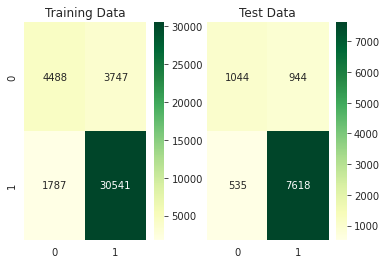

In [ ]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,y_pred_gb_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test, y_pred_gb)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

In [ ]:
# MSE
from sklearn import metrics

print('MSE:', metrics.mean_squared_error(y_test, y_pred_gb))

MSE: 0.1458436051671433


In [ ]:
# Create the parameter grid based on the results of random search
cv = KFold(n_splits=5, random_state=0, shuffle=True)
scores = cross_val_score(gb_cv, X_train,y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(scores)

[0.86047085 0.85418464 0.85738938 0.85897436 0.8640286 ]


## Catboost

In [ ]:
CBC = CatBoostClassifier()

In [ ]:
parameters = {'depth'         : [4,5,6,7],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations'    : [10, 20,30,40,50]
            }

In [ ]:
from sklearn.model_selection import GridSearchCV
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 5, n_jobs=-1)
Grid_CBC.fit(X_train, y_train)

0:	learn: 0.6720743	total: 10.8ms	remaining: 528ms
1:	learn: 0.6531866	total: 19.2ms	remaining: 461ms
2:	learn: 0.6354544	total: 26.3ms	remaining: 412ms
3:	learn: 0.6187552	total: 33.5ms	remaining: 385ms
4:	learn: 0.6031102	total: 40.6ms	remaining: 366ms
5:	learn: 0.5884116	total: 47.8ms	remaining: 351ms
6:	learn: 0.5746929	total: 55.2ms	remaining: 339ms
7:	learn: 0.5622492	total: 62.6ms	remaining: 328ms
8:	learn: 0.5501322	total: 69.8ms	remaining: 318ms
9:	learn: 0.5386647	total: 77.3ms	remaining: 309ms
10:	learn: 0.5284517	total: 84.2ms	remaining: 298ms
11:	learn: 0.5184343	total: 92.9ms	remaining: 294ms
12:	learn: 0.5089797	total: 100ms	remaining: 285ms
13:	learn: 0.5003126	total: 108ms	remaining: 277ms
14:	learn: 0.4919312	total: 115ms	remaining: 269ms
15:	learn: 0.4840474	total: 123ms	remaining: 260ms
16:	learn: 0.4766826	total: 130ms	remaining: 252ms
17:	learn: 0.4699354	total: 137ms	remaining: 243ms
18:	learn: 0.4634248	total: 143ms	remaining: 234ms
19:	learn: 0.4576785	total: 1

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f11eb318110>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7],
                         'iterations': [10, 20, 30, 40, 50],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]})

In [ ]:
y_pred_test = Grid_CBC.predict(X_test)
y_pred_train = Grid_CBC.predict(X_train)

In [ ]:
print("The best parameters :",Grid_CBC.best_params_)
print("\nTrain Score:",Grid_CBC.best_score_)
print("Test Score:",Grid_CBC.score(X_test, y_test))
print("Precision (Train Set): " ,precision_score(y_train, Grid_CBC.predict(X_train)))
print("Precision (Test Set):" ,precision_score(y_test, Grid_CBC.predict(X_test)))
print("Recall (Train Set): " ,recall_score(y_train, Grid_CBC.predict(X_train)))
print("Recall (Test Set): " ,recall_score(y_test, Grid_CBC.predict(X_test)))
print("F1-Score (Train Set): " ,f1_score(y_train, Grid_CBC.predict(X_train)))
print("F1-Score (Test Set): " ,f1_score(y_test, Grid_CBC.predict(X_test)))

The best parameters : {'depth': 7, 'iterations': 50, 'learning_rate': 0.04}

Train Score: 0.8564455140664737
Test Score: 0.8533675179962529
Precision (Train Set):  0.8826323516711287
Precision (Test Set): 0.8848729792147806
Recall (Train Set):  0.9484038604305864
Recall (Test Set):  0.9398994235250828
F1-Score (Train Set):  0.9143368373965556
F1-Score (Test Set):  0.9115565336346874


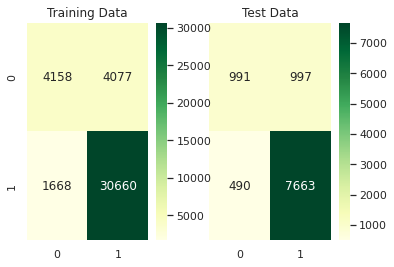

In [ ]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,y_pred_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,y_pred_test)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

In [ ]:
# print classification report

print('Classification Report Testing Model Catboost')
print(classification_report(y_test, y_pred_test))
print('\nClassification Report Training Model Catboost')
print(classification_report(y_train,y_pred_train))

Classification Report Testing Model Catboost
              precision    recall  f1-score   support

           0       0.67      0.50      0.57      1988
           1       0.88      0.94      0.91      8153

    accuracy                           0.85     10141
   macro avg       0.78      0.72      0.74     10141
weighted avg       0.84      0.85      0.84     10141


Classification Report Training Model Catboost
              precision    recall  f1-score   support

           0       0.71      0.50      0.59      8235
           1       0.88      0.95      0.91     32328

    accuracy                           0.86     40563
   macro avg       0.80      0.73      0.75     40563
weighted avg       0.85      0.86      0.85     40563



In [ ]:
# MSE
from sklearn import metrics

print('MSE:', metrics.mean_squared_error(y_test, y_pred_test))

MSE: 0.14663248200374718


**cross validation**

In [ ]:
# Create the parameter grid based on the results of random search
cv = KFold(n_splits=3, random_state=0, shuffle=True)

scores = cross_val_score(Grid_CBC, X=X_train, y=y_train, scoring='accuracy', cv=cv)
print(scores)

0:	learn: 0.6724518	total: 8.71ms	remaining: 427ms
1:	learn: 0.6533952	total: 15.3ms	remaining: 368ms
2:	learn: 0.6352880	total: 20.8ms	remaining: 326ms
3:	learn: 0.6188328	total: 26.4ms	remaining: 303ms
4:	learn: 0.6033442	total: 32.1ms	remaining: 289ms
5:	learn: 0.5886199	total: 37.7ms	remaining: 277ms
6:	learn: 0.5750487	total: 43.2ms	remaining: 266ms
7:	learn: 0.5624476	total: 48.8ms	remaining: 256ms
8:	learn: 0.5502589	total: 54.3ms	remaining: 248ms
9:	learn: 0.5387135	total: 59.9ms	remaining: 240ms
10:	learn: 0.5285229	total: 65.2ms	remaining: 231ms
11:	learn: 0.5183016	total: 70.8ms	remaining: 224ms
12:	learn: 0.5087951	total: 76.4ms	remaining: 217ms
13:	learn: 0.5001617	total: 82.1ms	remaining: 211ms
14:	learn: 0.4921059	total: 87.8ms	remaining: 205ms
15:	learn: 0.4844164	total: 93.3ms	remaining: 198ms
16:	learn: 0.4773150	total: 98.9ms	remaining: 192ms
17:	learn: 0.4708254	total: 104ms	remaining: 185ms
18:	learn: 0.4642464	total: 110ms	remaining: 179ms
19:	learn: 0.4580165	tot

##Decision Tree

**Hyperparameter Tuning with Random Search**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num=30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum member of samples required to split a node
min_samples_leaf = [1,2,4,10,20,50] # Minimum number of samples required at each leaf node
max_features = ['auto','sqrt'] # Number of features to consider at every split

hyperparameters = dict(max_depth=max_depth,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_features = max_features
                      )

# Initiate Model
dt = DecisionTreeClassifier()
model_dt_tuned = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='accuracy')
model_dt_tuned.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'max_depth': [1, 4, 8, 12, 16, 19, 23,
                                                      27, 31, 34, 38, 42, 46,
                                                      49, 53, 57, 61, 64, 68,
                                                      72, 76, 79, 83, 87, 91,
                                                      94, 98, 102, 106, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10, 20,
                                                             50],
                                        'min_samples_split': [2, 5, 10, 100]},
                   random_state=42, scoring='accuracy')

In [ ]:
y_pred = model_dt_tuned.predict(X_test)
y_pred_train = model_dt_tuned.predict(X_train)

In [ ]:
#Function Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model_dt_tuned, y_pred_train, y_pred, y_train, y_test):
    print('Accuracy (Train Set): ',accuracy_score(y_train, y_pred_train))
    print('Accuracy (Test Set): ',accuracy_score(y_test, y_pred))
    print("Precision (Train Set): " ,precision_score(y_train, y_pred_train))
    print("Precision (Test Set): " ,precision_score(y_test, y_pred))
    print("Recall (Train Set): " ,recall_score(y_train, y_pred_train))
    print("Recall (Test Set): " ,recall_score(y_test, y_pred))
    print("F1-Score (Train Set): " ,f1_score(y_train, y_pred_train))
    print("F1-Score (Test Set): " ,f1_score(y_test, y_pred))

    fpr, tpr, thresholds = roc_curve(y_train, y_pred_train, pos_label=1)
    print("AUC (Train Set) : " ,auc(fpr,tpr))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print("AUC (Test Set) : " ,auc(fpr,tpr))

In [ ]:
# Check Mmodel Performance after Hyperparameter Tuning
eval_classification(model_dt_tuned, y_pred_train, y_pred, y_train, y_test)

Accuracy (Train Set):  0.8498385227917067
Accuracy (Test Set):  0.839167734937383
Precision (Train Set):  0.8816957141610172
Precision (Test Set):  0.8798928238583411
Recall (Train Set):  0.9373608017817372
Recall (Test Set):  0.9264074573776524
F1-Score (Train Set):  0.9086765521687632
F1-Score (Test Set):  0.902551233793392
AUC (Train Set) :  0.7218072982800611
AUC (Test Set) :  0.7038978936787658


In [ ]:
# print best parameter
model_dt_tuned.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 50,
 'max_features': 'sqrt',
 'max_depth': 64}

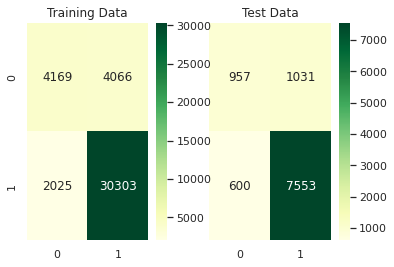

In [ ]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,y_pred_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,y_pred)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

In [ ]:
# predict data train
# print classification report
print('Classification Report Testing Model Decision Tree Classifier')
print(classification_report(y_test, y_pred))
print('\nClassification Report Training Model Decision Tree Classifier')
print(classification_report(y_train,y_pred_train))

Classification Report Testing Model Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.61      0.48      0.54      1988
           1       0.88      0.93      0.90      8153

    accuracy                           0.84     10141
   macro avg       0.75      0.70      0.72     10141
weighted avg       0.83      0.84      0.83     10141


Classification Report Training Model Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.67      0.51      0.58      8235
           1       0.88      0.94      0.91     32328

    accuracy                           0.85     40563
   macro avg       0.78      0.72      0.74     40563
weighted avg       0.84      0.85      0.84     40563



In [ ]:
# MSE
from sklearn import metrics

print('MSE:', metrics.mean_squared_error(y_test, y_pred))

MSE: 0.1608322650626171


**Cross Validation Metode Grid Search**

In [ ]:
# Create the parameter grid based on the results of random search
cv = KFold(n_splits=5, random_state=0, shuffle=True)

scores = cross_val_score(model_dt_tuned, X=X_train, y=y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(scores)

[0.84543326 0.84420067 0.84087267 0.84800296 0.85034517]


## Logistic Regression

In [ ]:
logModel = LogisticRegression()
param_grid = [
    {'penalty' : ['l1', 'l2'],
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'solver' : ['lbfgs','newton-cg','liblinear'],
    'max_iter' : [100, 1000]
    }
]
clf = GridSearchCV(logModel, param_grid = param_grid, scoring='accuracy', verbose=True, n_jobs=-1)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [100, 10, 1.0, 0.1, 0.01],
                          'max_iter': [100, 1000], 'penalty': ['l1', 'l2'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear']}],
             scoring='accuracy', verbose=True)

In [ ]:
clf.best_estimator_

LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear')

In [ ]:
print("Train Score:",clf.best_score_)
print("Test Score:",metrics.accuracy_score(clf.predict(X_test),y_test))
print("Precision (Train Set): " ,precision_score(y_train, clf.predict(X_train)))
print("Precision (Test Set): ",precision_score(y_test, clf.predict(X_test)))
print("Recall (Train Set): " ,recall_score(y_train, clf.predict(X_train)))
print("Recall (Test Set): " ,recall_score(y_test, clf.predict(X_test)))
print("F1-Score (Train Set): " ,f1_score(y_train, clf.predict(X_train)))
print("F1-Score (Test Set): " ,f1_score(y_test, clf.predict(X_test)))

Train Score: 0.8418262438762538
Test Score: 0.8446898727936101
Precision (Train Set):  0.8554967214464045
Precision (Test Set):  0.8603988603988604
Recall (Train Set):  0.964550853749072
Recall (Test Set):  0.9630810744511222
F1-Score (Train Set):  0.9067566192186342
F1-Score (Test Set):  0.9088488917182708


In [ ]:
# predict data train
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# print classification report
print('Classification Report Testing Model Logistic Regression')
print(classification_report(y_test, clf.predict(X_test)))
print('\nClassification Report Training Model Decision Tree Classifier')
print(classification_report(y_train,clf.predict(X_train)))

Classification Report Testing Model Logistic Regression
              precision    recall  f1-score   support

           0       0.70      0.36      0.48      1988
           1       0.86      0.96      0.91      8153

    accuracy                           0.84     10141
   macro avg       0.78      0.66      0.69     10141
weighted avg       0.83      0.84      0.82     10141


Classification Report Training Model Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.72      0.36      0.48      8235
           1       0.86      0.96      0.91     32328

    accuracy                           0.84     40563
   macro avg       0.79      0.66      0.69     40563
weighted avg       0.83      0.84      0.82     40563



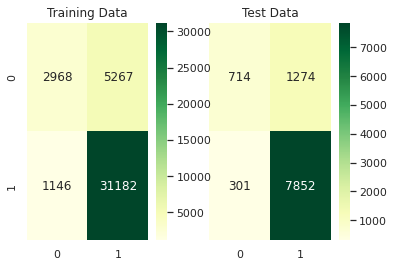

In [ ]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,clf.predict(X_train))),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,clf.predict(X_test))),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

In [ ]:
# MSE
from sklearn import metrics

print('MSE:', metrics.mean_squared_error(y_test,clf.predict(X_test)))

MSE: 0.1553101272063899


**Cross Validation**

In [ ]:
# # Create the parameter grid based on the results of random search
cv = KFold(n_splits=5,random_state=1,shuffle=True)
scores = cross_val_score(clf, X_train,y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(scores)

[0.83397017 0.84062616 0.84617281 0.84270217 0.84529093]


##KNN

In [ ]:
model=KNeighborsClassifier()
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 10, cv=3, n_jobs = -1)
# fit the model on our train set
g_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [ ]:
# get the hyperparameters with the best score
gs.best_params_

{'metric': 'minkowski', 'n_neighbors': 15, 'weights': 'uniform'}

In [ ]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 15, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=15)

In [ ]:
# get a prediction
y_train_knn = knn.predict(X_train)
y_test_knn = knn.predict(X_test)

In [ ]:
print('Training set accuracy: ', metrics.accuracy_score(y_train, y_train_knn))
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_test_knn))
print("Precision (Train Set):",precision_score(y_train, knn.predict(X_train)))
print("Precision (Test Set): " ,precision_score(y_test, knn.predict(X_test)))
print("Recall (Train Set): ",recall_score(y_train, knn.predict(X_train)))
print("Recall (Test Set): ",recall_score(y_test, knn.predict(X_test)))
print("F1-Score (Train Set): " ,f1_score(y_train, knn.predict(X_train)))
print("F1-Score (Test Set): " ,f1_score(y_test, knn.predict(X_test)))

Training set accuracy:  0.8515395804057885
Test set accuracy:  0.8354205699635144
Precision (Train Set): 0.8657675194660734
Precision (Test Set):  0.8588665043170246
Recall (Train Set):  0.963035139816877
Recall (Test Set):  0.9516742303446584
F1-Score (Train Set):  0.9118146672914715
F1-Score (Test Set):  0.9028917204864141


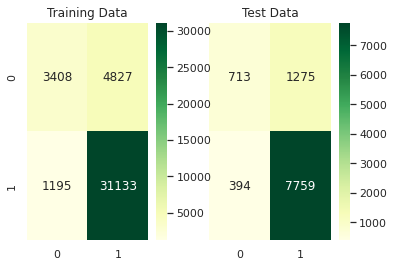

In [ ]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)
#Plotting confusion matrix for the different models for the Training Data
plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,y_train_knn)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,y_test_knn)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

In [ ]:
print('Classification Report Testing Model KNN')
print(classification_report(y_test, y_test_knn))
print('\nClassification Report Training Model KNN')
print(classification_report(y_train,y_train_knn))

Classification Report Testing Model KNN
              precision    recall  f1-score   support

           0       0.64      0.36      0.46      1988
           1       0.86      0.95      0.90      8153

    accuracy                           0.84     10141
   macro avg       0.75      0.66      0.68     10141
weighted avg       0.82      0.84      0.82     10141


Classification Report Training Model KNN
              precision    recall  f1-score   support

           0       0.74      0.41      0.53      8235
           1       0.87      0.96      0.91     32328

    accuracy                           0.85     40563
   macro avg       0.80      0.69      0.72     40563
weighted avg       0.84      0.85      0.83     40563



In [ ]:
# MSE
from sklearn import metrics

print('MSE:', metrics.mean_squared_error(y_test, y_test_knn))

MSE: 0.16457943003648556


**Cross Validation**

In [ ]:
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=5, random_state=0, shuffle=True)
scores = cross_val_score(knn, X=X_train, y=y_train, cv =cv)
print(scores)

[0.83470973 0.83261432 0.84013312 0.83814103 0.83604536]


#**Evaluation**

**Best Model : Gradient Boosting Classifier**

In [ ]:
prediction=gb_cv.predict(X_test)

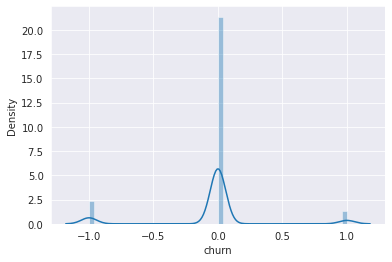

In [ ]:
# checking difference between labled y and predicted y
sns.distplot(y_test-prediction)

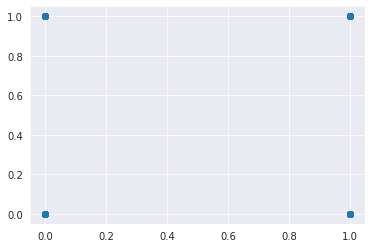

In [ ]:
#checking predicted y and labeled y using a scatter plot.
plt.scatter(y_test,prediction)

In [ ]:
y_pred_gb = gb_cv.predict(X_test)
y_pred_gb_train = gb_cv.predict(X_train)
# print classification report

print('Classification Report Testing Model Random Forest')
print(classification_report(y_test, y_pred_gb))
print('\nClassification Report Training Model Random Forest')
print(classification_report(y_train,y_pred_gb_train))

Classification Report Testing Model Random Forest
              precision    recall  f1-score   support

           0       0.66      0.53      0.59      1988
           1       0.89      0.93      0.91      8153

    accuracy                           0.85     10141
   macro avg       0.78      0.73      0.75     10141
weighted avg       0.84      0.85      0.85     10141


Classification Report Training Model Random Forest
              precision    recall  f1-score   support

           0       0.72      0.54      0.62      8235
           1       0.89      0.94      0.92     32328

    accuracy                           0.86     40563
   macro avg       0.80      0.74      0.77     40563
weighted avg       0.86      0.86      0.86     40563



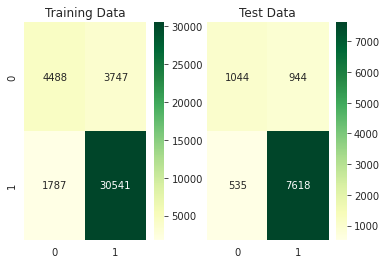

In [ ]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,y_pred_gb_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test, y_pred_gb)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

In [ ]:
# MAE, MSE, RMSE With hyperparameter tuned

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,gb_cv.predict(X_test)))
print('MSE:', metrics.mean_squared_error(y_test, gb_cv.predict(X_test)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, gb_cv.predict(X_test))))

MAE: 0.1458436051671433
MSE: 0.1458436051671433
RMSE: 0.38189475666359085


Feature: total_promo_amount Score:  0.019171989052701444 %
Feature: number_of_transaction Score:  0.7736733555944113 %
Feature: number_of_promo Score:  0.1396048736694584 %
Feature: transaction_failed Score:  0.01385407394376604 %
Feature: event_name Score:  0.052329760266401154 %
Feature: home_location Score:  0.0008930202620951845 %
Feature: delivery_time Score:  0.00047279862048935014 %
Feature: shipment_fee Score:  1.2859067699052285e-07 %


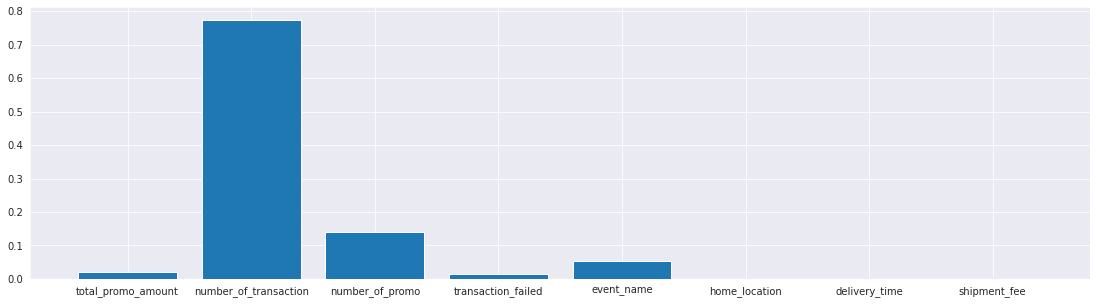

In [ ]:
# Features Importance
import matplotlib.pyplot as plt
model_gb = GradientBoostingClassifier()
model_gb = model_gb.fit(X_train,y_train)

import matplotlib.pyplot as plt

importance = model_gb.feature_importances_
feature_cols = ['total_promo_amount','number_of_transaction','number_of_promo','transaction_failed','event_name','home_location','delivery_time','shipment_fee']
for i,v in enumerate(importance):
	print('Feature:', feature_cols[i],'Score: ', v, '%')
# plot feature importance
plt.figure(figsize=(19,5))
plt.bar([X for X in feature_cols], importance)
plt.show()

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean

# define the model
model = GradientBoostingClassifier()
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=1)
# evaluate the model on the dataset
n_scores = cross_val_score(model, X_train,y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print(n_scores)
print('\nMean Accuracy: %.2f (%.2f)' % (mean(n_scores), np.std(n_scores)))

[0.86074202 0.85625539 0.85677308 0.85970664 0.85953408 0.86054539
 0.86158095 0.8672994  0.86281277 0.86022433 0.85418464 0.85918896
 0.86106317 0.8491543  0.86143227 0.86402071 0.85901639 0.85608283
 0.85401208 0.85467725 0.86020021]

Mean Accuracy: 0.86 (0.00)


## Save Model

In [ ]:
import pickle
filename = 'model_teamjerman.pkl'
pickle.dump(gb_tuned, open(filename, 'wb'))

# Conclusion & Recommendations



**Conclusion**
- The Gradient Boosting model is able to make predictions with fairly good model performance. The accuracy of the model in predicting customer churn is 86%.

- Of the total 8 features as variable X, the variables that have the most positive effect on customer churn are total_promo_amount, number_of_transaction, and number_of_promo.

**Recommendations**
1. Develop New Features

    Add a new features to review products and services to find out the level of customer satisfaction

2.  Develop a Questionnaire

    Develop product reviews through a questionnaire, and send a feedback form via email to the customer regarding customer satisfaction with the product and user experiences
3. Rewards for Loyal User

    Give rewards to loyal customers, such as discounts, free gifts, and reduced shipping costs.